# Imports

In [1]:
# Our tools
import exoplanet as xo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares
from scipy import stats
import graphviz
import astropy.units as u

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx
from functools import partial

import os
import warnings
#os.environ["MKL_THREADING_LAYER"] = "GNU"
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-dark-palette')

/tmp/ipykernel_4758/1667230561.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [3]:
plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

# Data

## Tess

In [4]:
#sectors times, 15-22-23-48-50
from astropy.time import Time
sectors = ['2019-08-15T20:45:00','2019-09-10T22:00:00','2020-02-19T19:20:00','2020-03-18T00:00:00',
'2020-03-19T14:30:00','2020-04-15T09:10:00','2022-01-28T10:25:00','2022-02-25T11:50:00','2022-03-26T18:30:00','2022-04-22T00:25:00']
sectors_times = Time(sectors, format='fits')
sectors_times_btjd = sectors_times.jd-2457000
sectors_times_btjd

array([1711.36458333, 1737.41666667, 1899.30555556, 1926.5       ,
       1928.10416667, 1954.88194444, 2607.93402778, 2635.99305556,
       2665.27083333, 2691.51736111])

In [5]:
lk.search_targetpixelfile('TIC 445859771')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,445859771,0.0
1,TESS Sector 15,2019,TESS-SPOC,1800,445859771,0.0
2,TESS Sector 16,2019,TESS-SPOC,1800,445859771,0.0
3,TESS Sector 22,2020,SPOC,120,445859771,0.0
4,TESS Sector 22,2020,TESS-SPOC,1800,445859771,0.0
5,TESS Sector 23,2020,SPOC,120,445859771,0.0
6,TESS Sector 23,2020,TESS-SPOC,1800,445859771,0.0
7,TESS Sector 48,2022,SPOC,120,445859771,0.0
8,TESS Sector 48,2022,TESS-SPOC,600,445859771,0.0


In [6]:
tpf = lk.search_targetpixelfile('TIC 445859771', exptime='short', sector=22).download(quality_bitmask='default')

<Axes: title={'center': 'Target ID: 445859771, Cadence: 483733'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

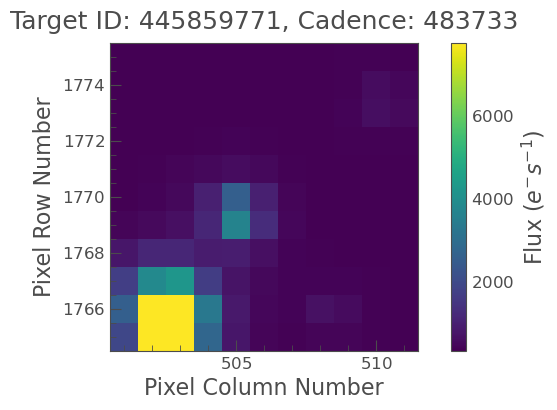

In [7]:
tpf.plot()

In [8]:
# !python ~/Descargas/tpfplotter/tpfplotter.py 445859771 --maglim 6 --sector 50 

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
     tpfplotter       

* Working on TIC445859771 (ra = 214.120551833405, dec = 58.3904447547356) ...
1611685760565507840
INFO: Query finished. [astroquery.utils.tap.core]
	 --> Target found in the CTL!
	 --> Using pipeline aperture...
	 --> TPF plot written in file: TPF_Gaia_TIC445859771_S50.pdf
	 --> Done!



In [9]:
lk.search_lightcurve('TIC 445859771')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,445859771,0.0
1,TESS Sector 15,2019,TESS-SPOC,1800,445859771,0.0
2,TESS Sector 15,2019,QLP,1800,445859771,0.0
3,TESS Sector 15,2019,TASOC,120,445859771,0.0
4,TESS Sector 15,2019,TASOC,1800,445859771,0.0
5,TESS Sector 15,2019,TASOC,1800,445859771,0.0
6,TESS Sector 16,2019,TESS-SPOC,1800,445859771,0.0
7,TESS Sector 16,2019,QLP,1800,445859771,0.0
8,TESS Sector 22,2020,SPOC,120,445859771,0.0


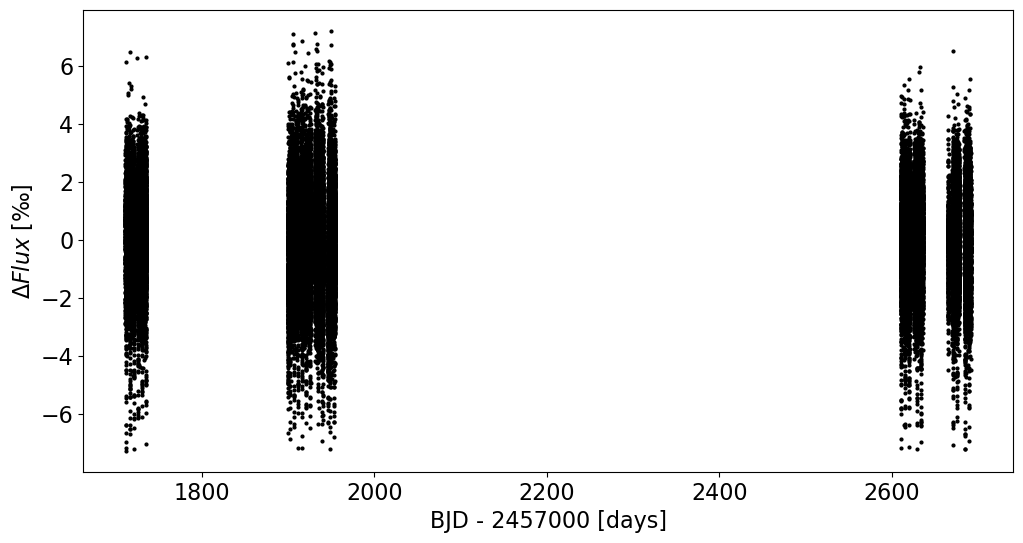

In [10]:
lc_file = lk.search_lightcurve('TIC 445859771', author='SPOC').download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr_ = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

plt.figure(figsize=(12, 6))
plt.plot(time, y_, "o", color='black',markersize=2)
#plt.errorbar(time, (flux-1.0)*1e3, yerr=lc.flux_err*1e3, color='k', fmt='o', ms=2)
plt.xlabel("BJD - 2457000 [days]")
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.show()
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight')

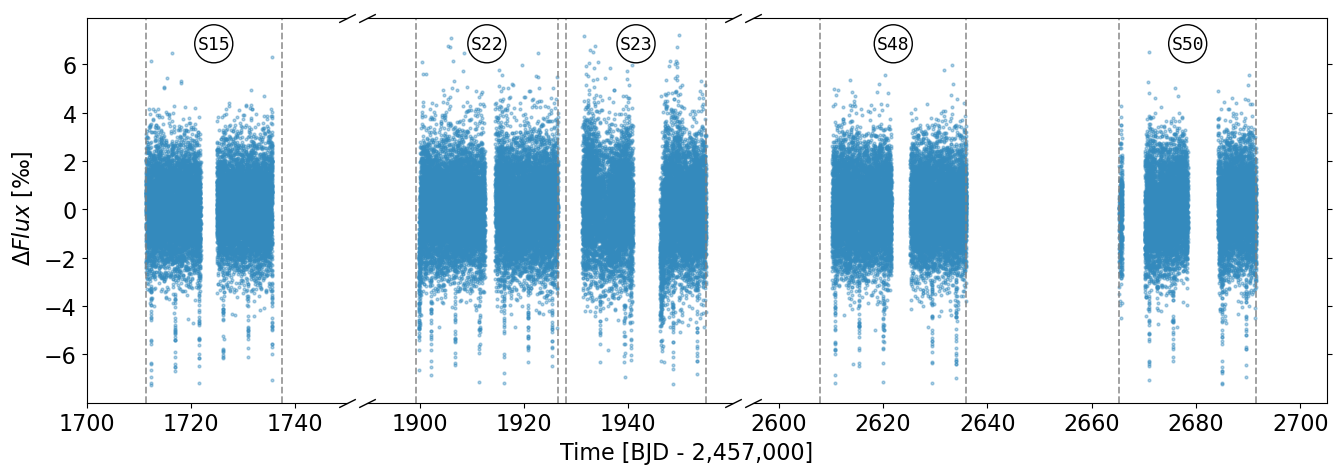

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16,5), gridspec_kw={'width_ratios': [1, 1.4, 2.2]})
fig.subplots_adjust(wspace=0.05)
ax1.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.4)
ax2.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.4)
ax3.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.4)
off=15
ax1.set_xlim(1700, 1750)  
ax2.set_xlim(1890, 1960)  
ax3.set_xlim(2595, 2705)  
ax2.set_xticks([1900, 1920, 1940])
ax1.spines.right.set_visible(False)
ax2.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax3.spines.left.set_visible(False)
ax1.yaxis.tick_left()
#ax2.set_yticks([])
ax2.yaxis.tick_right()
ax3.yaxis.tick_right()
ax1.tick_params(labelright=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelright=False)
ax2.tick_params(labelleft=False)
ax3.tick_params(labelleft=False)

d = .5  
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)

ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
ax2.plot([1, 1], [0, 1], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 0], [1, 0], transform=ax3.transAxes, **kwargs)
for i in sectors_times_btjd[:2]:
    ax1.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[2:6]:
    ax2.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[6:]:
    ax3.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
ax1.text(sectors_times_btjd[0]+(sectors_times_btjd[1]-sectors_times_btjd[0])/2, 6.85, 
    "S15", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax2.text(sectors_times_btjd[2]+(sectors_times_btjd[3]-sectors_times_btjd[2])/2, 6.85, 
    "S22", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax2.text(sectors_times_btjd[4]+(sectors_times_btjd[5]-sectors_times_btjd[4])/2, 6.85, 
    "S23", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax3.text(sectors_times_btjd[6]+(sectors_times_btjd[7]-sectors_times_btjd[6])/2, 6.85, 
    "S48", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax3.text(sectors_times_btjd[8]+(sectors_times_btjd[9]-sectors_times_btjd[8])/2, 6.85, 
    "S50", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))

fig.text(0.5, 0.01, "Time [BJD - 2,457,000]", ha='center', va='center')
fig.text(0.085, 0.5, u'$\Delta Flux$ [‰]', ha='center', va='center', rotation='vertical')
#plt.savefig('tessdata_1273.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

BLS

In [12]:
period_grid = np.exp(np.linspace(np.log(2), np.log(8), 30000)) #2 y 8 ---- 1 y 30
durations = np.exp(np.linspace(np.log(0.01), np.log(0.2), 100)) #0.01 y 0.2 

bls = BoxLeastSquares(x_, y_, yerr_)
bls_power = bls.power(period_grid, durations, oversample=30)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
bls_duration = bls_power.duration[index]

print('bls period:',bls_period)
print('bls t0:',bls_t0)
print('bls depth:',bls_depth)
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)
print('bls duration:', bls_duration)

bls period: 4.631374375019575
bls t0: -489.0987763358155
bls depth: 3.6049340566184895
ref_time: 2201.436872421974
epoch: 1712.3380960861584
bls duration: 0.05266666666666668


In [13]:
# 1 y 30 grid
# bls period: 4.631191916352005
# bls t0: -489.0772763358155
# bls depth: 3.6220594837807694
# ref_time: 2201.436872421974
# epoch: 1712.3595960861585
# bls duration: 0.04833333333333336

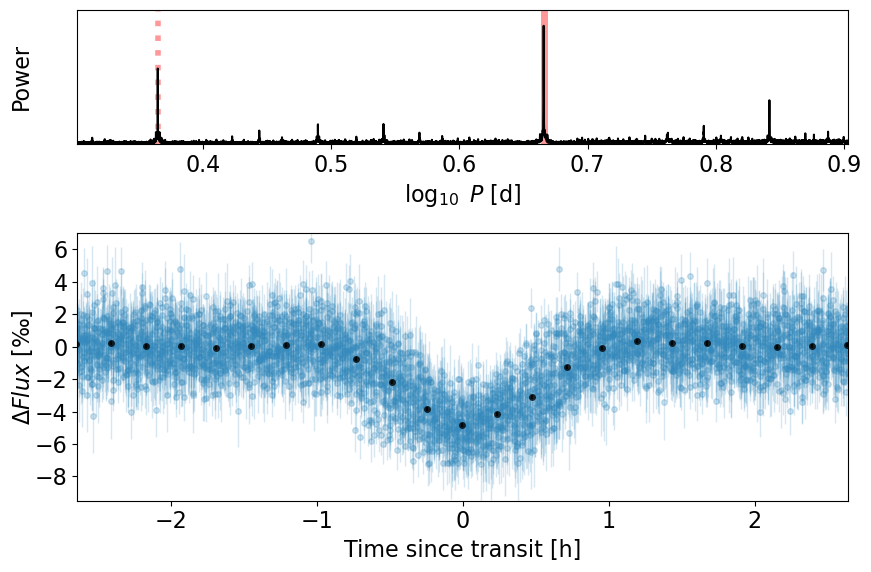

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), gridspec_kw={'height_ratios': [1, 2]})
fig.subplots_adjust(hspace=0.35)

ax1.axvline(np.log10(bls_period), color='red', lw=5, alpha=0.4)
ax1.axvline(np.log10(bls_period/2), linestyle='dotted', color='red', lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/3), linestyle='dotted', color='red', lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*3), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.plot(np.log10(bls_power.period), bls_power.power, color="k")
ax1.set_ylim(0,3000)
ax1.set_ylabel("Power", labelpad=32)
ax1.set_yticks([])
ax1.set_xlim(np.log10(period_grid.min())+0.001, np.log10(period_grid.max()))
ax1.set_xlabel(r"$\log_{10}~ P$ [d]")

# Plot the folded transit
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold_) < 0.4
ax2.plot(x_fold_*24, y_, ".", alpha=0.25, ms=8, color='#348ABD')
ax2.errorbar(x_fold_*24, y_, yerr=yerr_, color='#348ABD', fmt="none", capsize=0, elinewidth=1, zorder=-1000, alpha=0.2)

# Overplot the phase binned light curve
lcc = lk.LightCurve(time=x_fold_, flux=y_, flux_err=yerr_)
lcc_binned = lcc.bin(time_bin_size=0.01)
ax2.errorbar(lcc_binned['time'].value*24, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
                ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, capsize=2, alpha=0.8)
ax2.set_xlim(-0.11*24, 0.11*24)
ax2.set_ylim(-9.5, 7)
ax2.set_yticks([-8,-6,-4,-2,0,2,4,6])
ax2.set_ylabel(u'$\Delta Flux$ [‰]', labelpad=0)
_ = ax2.set_xlabel("Time since transit [h]")
plt.tight_layout()

#plt.savefig('bls_paper_1273.png',dpi=300,bbox_inches='tight', facecolor='white')

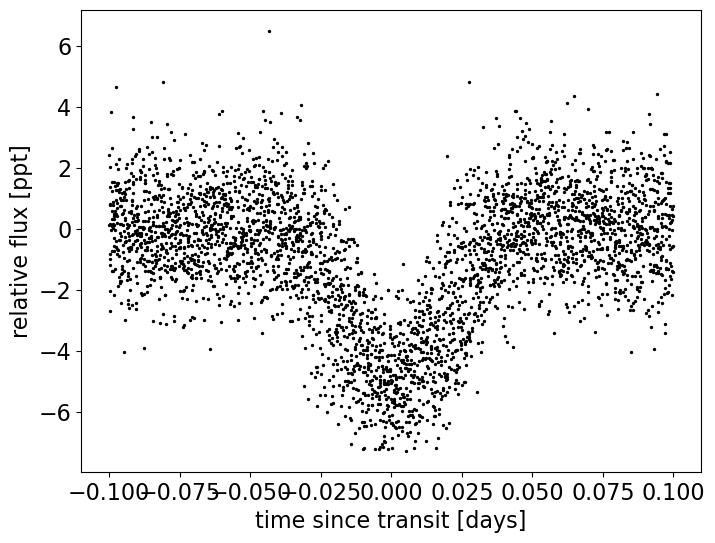

In [15]:
transit_mask = bls.transit_mask(x_, bls_period, 0.2, bls_t0)
x_fold_ = (x_ - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period

# Me quedo solo con los puntos cerca de los transitos
x_fold = x_fold_[transit_mask]
x = x_[transit_mask]
y = y_[transit_mask]
yerr = yerr_[transit_mask]

plt.scatter(x_fold, y, c='k', s=2)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]");
#plt.xlim(-0.12,0.12)

## SOPHIE RVs

60


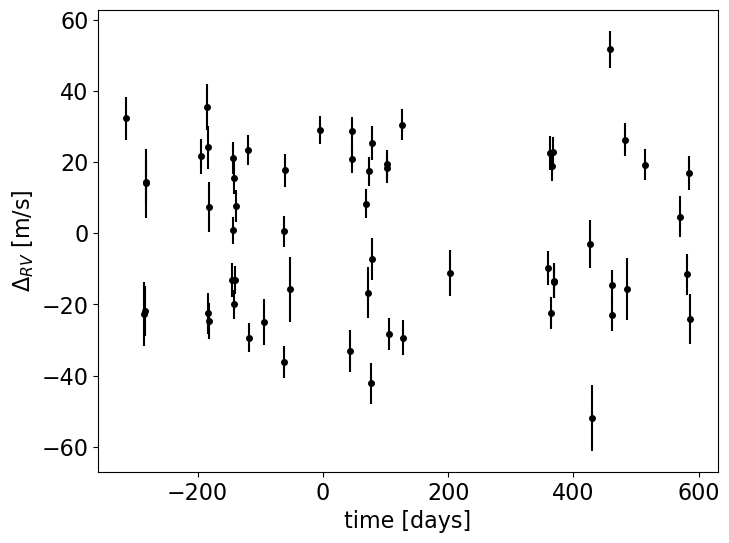

In [16]:
data = pd.read_table('./data/rvs/1273_final_rvs.dat', sep='\s+')
data.rename(columns={'rv(km/s)': 'rv', 'sigRV(km/s)':'err', 'bis(km/s)': 'bis'}, inplace=True)

x_rv = np.array(data.bjd+2400000-2457000)-ref_time
y_rv = np.array((data.rv-data.rv.mean())*1000)
yerr_rv = np.array(data.err*1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k", markersize=8)
plt.xlabel("time [days]")
print(len(x_rv))
_ = plt.ylabel("$\Delta_{RV}$ [m/s]")

In [17]:
# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x_rv.min() + x_rv.max())

# Stellar parameters from Sousa
M_star = 0.98, 0.02
R_star = 1.07, 0.03

K = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0)
print('K=', K, "m/s")

msini = xo.estimate_minimum_mass(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0, m_star=M_star[0])
msini = msini.to(u.M_earth)
print('minimum mass=', msini)

K= [26.47708999] m/s
minimum mass= [68.09246812] earthMass


Periodograms

In [18]:
from astropy.timeseries import LombScargle

In [19]:
# read de BIS data
ls = LombScargle(data.bjd, data.rv, data.err)
ls_bis = LombScargle(data.bjd, data.bis)

frequency, power = ls.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)

frequency_bis, power_bis = ls_bis.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)

probabilities = [0.1, 0.05, 0.01]
faps = ls.false_alarm_level(probabilities)  
faps_bis = ls_bis.false_alarm_level(probabilities)

In [20]:
# compute model

In [21]:
# aliases computed in DACE
aliases = [1.275, 1.271, 0.822, 0.821]

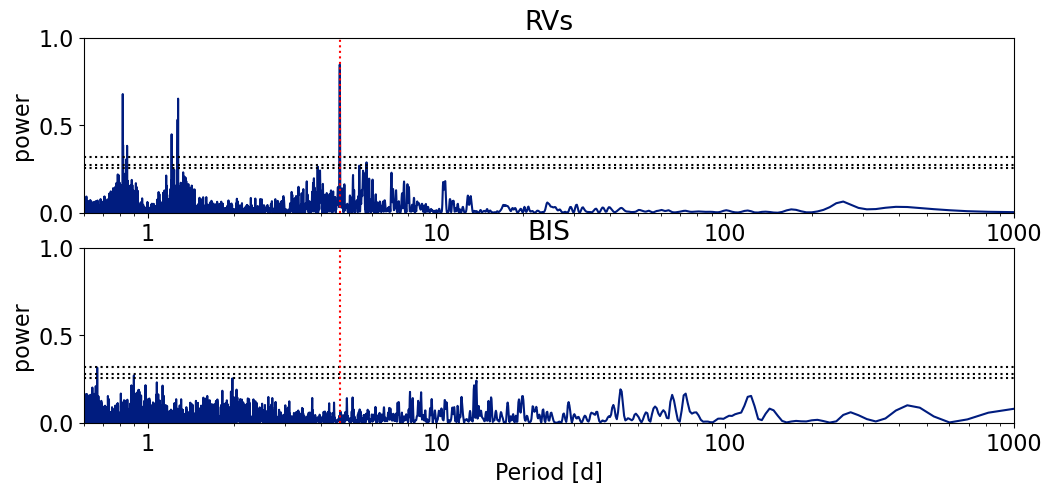

In [22]:
from matplotlib.ticker import ScalarFormatter
# plot two figures in a column
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(12, 5))
axes[0].plot(1/frequency, power, label='RVs') 
axes[1].plot(1/frequency_bis, power_bis, label='BIS') 

axes[0].set_xlabel('')
axes[0].set_xlim(0.6, 1000)
axes[0].set_ylim(0, 1.0)
axes[1].set_xlabel('Period [d]')
axes[1].set_xlim(0.6, 1000)
axes[1].set_ylim(0, 1.0)

axes[0].set_xscale('log')
axes[1].set_xscale('log')

axes[0].set_ylabel('power')
axes[1].set_ylabel('power')
axes[0].title.set_text('RVs')
axes[1].title.set_text('BIS')

# overplot the false alarm probabilities
for i, prob in enumerate(probabilities):
    axes[0].axhline(faps[i], ls=':', color='black', label='{}%'.format(prob))
    axes[1].axhline(faps_bis[i], ls=':', color='black', label='{}%'.format(prob))

# plot the 'bls_period' as a vertical line behind the plot
axes[0].axvline(bls_period, ls=':', color='red', label='bls period')
axes[1].axvline(bls_period, ls=':', color='red', label='bls period')

formatter = ScalarFormatter()
axes[0].xaxis.set_major_formatter(formatter)
axes[1].xaxis.set_major_formatter(formatter)

plt.show()

BIS vs rvs

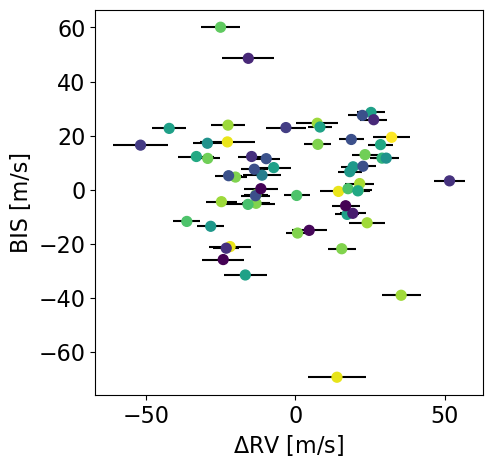

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(y_rv, data.bis*1e3, c=data.bjd, cmap='viridis_r', s=50, zorder=10)
# add errorbars on data.rv
ax.errorbar(y_rv, data.bis*1e3, xerr=yerr_rv, fmt='none', ecolor='k', markersize=8, zorder=-10)
ax.set_xlabel("$\Delta$RV [m/s]")
ax.set_ylabel("BIS [m/s]")
#plt.savefig('bisrv_1273.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## Ground LCs

### Keplercam

In [24]:
# all have the same columns
data1 = pd.read_table('./data/photom/TOI1273/KEPLERCAM/TIC445859771.01_UT2020.0213_KeplerCam_B.txt', sep='\s+')

In [25]:
#puntos?
print('puntos:', len(data1))
# texp?
texp_keplercam = None

puntos: 135


In [26]:
data1['flux'] = ((data1['rel_flux_T1']/(data1['rel_flux_T1'].median())))*1e3
data1['time'] = data1['BJD_TDB']-2457000-ref_time
data1['flux_err'] = ((data1['rel_flux_err_T1']/(data1['rel_flux_T1'].median())))*1e3

Text(0.5, 1.0, 'TOI1273')

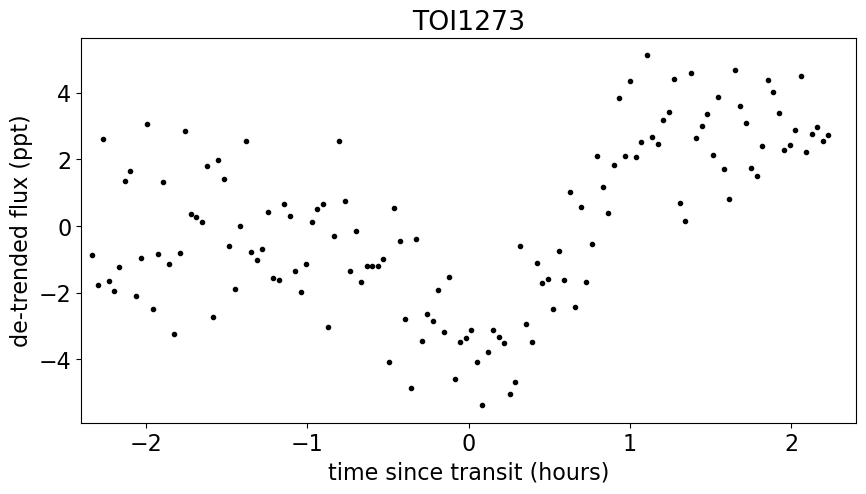

In [27]:
# Plot the folded data, con los parametros del BLS
data1_fold = (data1['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
plt.figure(figsize=(10, 5))
plt.plot(data1_fold*24, data1['flux']-1e3, ".k", label="data1", zorder=-1000)
plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
plt.xlim(-0.10*24, 0.10*24)
plt.title("TOI1273")

In [28]:
# ajustemos un pol grado 2 a los datos oot
# mascaras para sacar los datos en transito
oot_mask1 = bls.transit_mask(data1['time'], bls_period, bls_duration, bls_t0)
x_oot_B = (data1_fold*24)[~oot_mask1]
y_oot_B = data1['flux'][~oot_mask1]
z_B = np.polyfit(x_oot_B, y_oot_B, 2)
def pol_B(x):
    return np.asarray(z_B[0]*x**2 + z_B[1]*x + z_B[2])

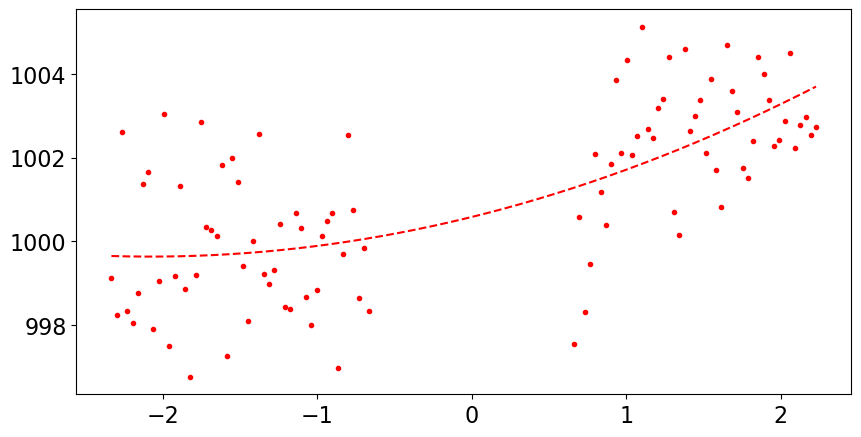

In [29]:
plt.figure(figsize=(10, 5))
plt.plot((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1], ".r", label="data1", zorder=-1000)
x_plot_B = np.linspace(np.min(x_oot_B), np.max(x_oot_B), 1000)
plt.plot(x_plot_B, pol_B(x_plot_B), color="r", linestyle="--")


In [30]:
x_conc_B = data1_fold*24
y_conc_B = (data1['flux']/pol_B(data1_fold*24)-1)*1e3
yerr_conc_B = data1['flux_err']

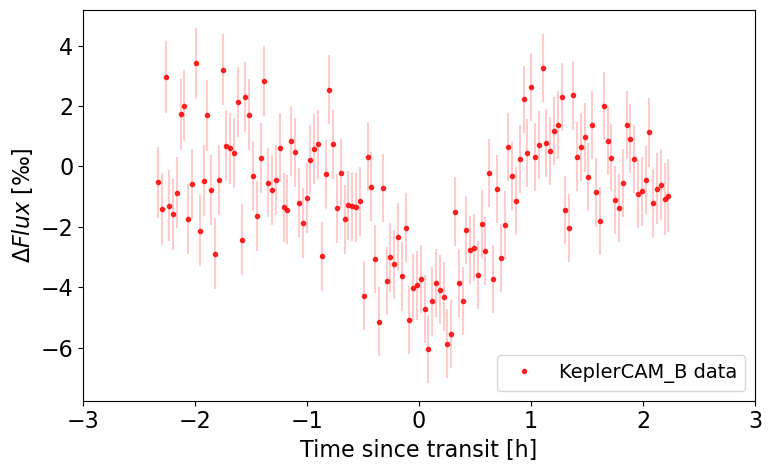

In [86]:
#replot dividing by polynomial
plt.figure(figsize=(8, 5))
# Plot the data
plt.plot(x_conc_B, y_conc_B, 'o', ms=3, color='r', 
         label='KeplerCAM_B data', zorder=1000, alpha=0.8)
plt.errorbar(x_conc_B, y_conc_B, yerr=yerr_conc_B, 
             fmt="none", color='r', capsize=0, zorder=-1000, alpha=0.2)
plt.legend(fontsize=14, loc=4)
plt.xlim(-3,3)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time since transit [h]")
plt.tight_layout()
#plt.savefig('new_phot_1199_keplercam.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

In [91]:
data1_ = pd.read_table('./data/photom/TOI1273/KEPLERCAM/TIC445859771.01_UT2020.0213_KeplerCam_B.tbl', sep='\s+')
data1_['flux'] = data1_['rel_flux_T1_dn']*1e3
data1_['time'] = data1_['BJD_TDB']-2457000-ref_time
data1_['flux_err'] = data1_['rel_flux_err_T1_dn']*1e3
data1_fold_ = (data1_['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period

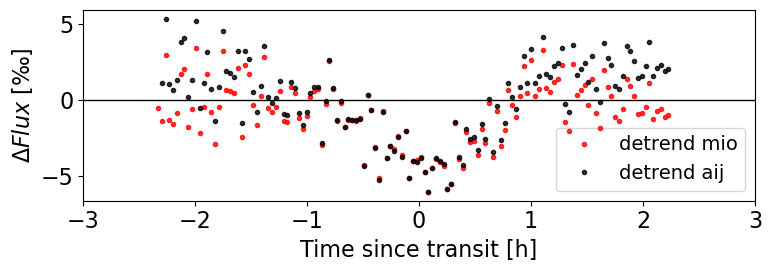

In [96]:
#replot dividing by polynomial
plt.figure(figsize=(8, 3))
# Plot the data
plt.plot(x_conc_B, y_conc_B, 'o', ms=3, color='r', label='detrend mio', zorder=1000, alpha=0.8)
plt.plot(data1_fold_*24, data1_['flux']-1e3, 'o', ms=3, label='detrend aij', color='k', zorder=1000, alpha=0.8)
plt.legend(fontsize=14, loc=4)
# horizontal line at 0
plt.axhline(0, color='k', lw=1)
plt.xlim(-3,3)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time since transit [h]")
plt.tight_layout()
#plt.savefig('new_phot_1199_keplercam.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

In [32]:
# datos de keplercam finales
x_keplercam_B = np.ascontiguousarray(data1['time'], dtype=np.float64)
y_keplercam_B = np.ascontiguousarray(y_conc_B, dtype=np.float64)
yerr_keplercam_B = np.ascontiguousarray(yerr_conc_B, dtype=np.float64)

### Muscat

In [33]:
data2 = pd.read_table('./data/photom/TOI1273/MUSCAT/TOI1273-01_20200218_zs_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data3 = pd.read_table('./data/photom/TOI1273/MUSCAT/TOI1273-01_20200218_g_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data4 = pd.read_table('./data/photom/TOI1273/MUSCAT/TOI1273-01_20200218_i_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data5 = pd.read_table('./data/photom/TOI1273/MUSCAT/TOI1273-01_20200218_r_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
# Convert time to the same reference time as tess and flux to ppt
data2['bjd'] = data2['BJD_TDB']-2457000-ref_time
data3['bjd'] = data3['BJD_TDB']-2457000-ref_time
data4['bjd'] = data4['BJD_TDB']-2457000-ref_time
data5['bjd'] = data5['BJD_TDB']-2457000-ref_time

data2['flux'] = np.ascontiguousarray(1e3 * (data2['flux'] - 1.0), dtype=np.float64) 
data3['flux'] = np.ascontiguousarray(1e3 * (data3['flux'] - 1.0), dtype=np.float64) 
data4['flux'] = np.ascontiguousarray(1e3 * (data4['flux'] - 1.0), dtype=np.float64) 
data5['flux'] = np.ascontiguousarray(1e3 * (data5['flux'] - 1.0), dtype=np.float64) 

data2['flux_err'] = np.ascontiguousarray(1e3 * (data2['flux_err']), dtype=np.float64) 
data3['flux_err'] = np.ascontiguousarray(1e3 * (data3['flux_err']), dtype=np.float64) 
data4['flux_err'] = np.ascontiguousarray(1e3 * (data4['flux_err']), dtype=np.float64) 
data5['flux_err'] = np.ascontiguousarray(1e3 * (data5['flux_err']), dtype=np.float64) 

In [34]:
print(len(data2), len(data3), len(data4), len(data5))

1772 1771 1772 1770


In [35]:
# Texp?
print(np.median(np.diff(data2['bjd']))*24*60*60)
texp_muscat = None

9.049759805202484


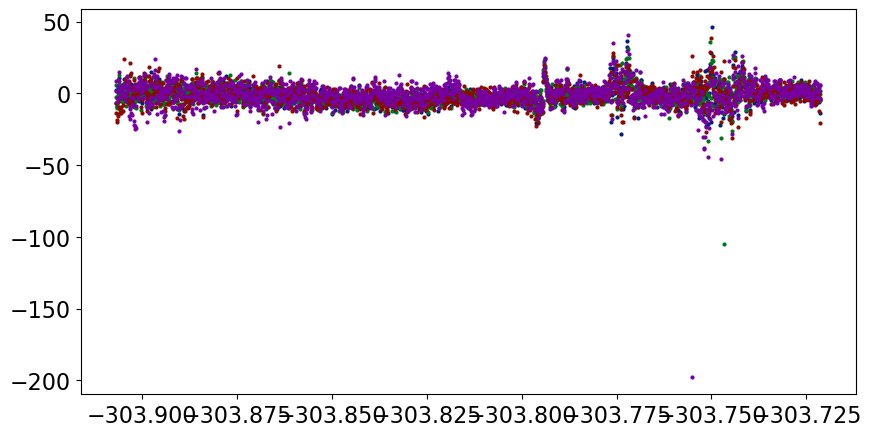

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(data2.bjd, data2.flux, 'o', label='z', ms=2)
plt.plot(data3.bjd, data3.flux, 'o', label='z', ms=2)
plt.plot(data4.bjd, data4.flux, 'o', label='z', ms=2)
plt.plot(data5.bjd, data5.flux, 'o', label='z', ms=2)
plt.show()

In [37]:
# remove outliers 
data2 = data2[np.abs(data2.flux - np.median(data2.flux)) < 3 * np.std(data2.flux)]
data3 = data3[np.abs(data3.flux - np.median(data3.flux)) < 3 * np.std(data3.flux)]
data4 = data4[np.abs(data4.flux - np.median(data4.flux)) < 3 * np.std(data4.flux)]
data5 = data5[np.abs(data5.flux - np.median(data5.flux)) < 3 * np.std(data5.flux)]

In [38]:
print(len(data2), len(data3), len(data4), len(data5))

1746 1748 1747 1756


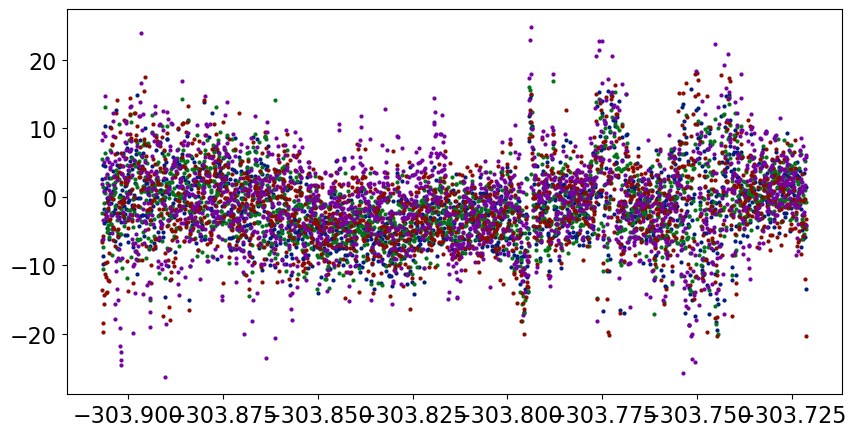

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(data2.bjd, data2.flux, 'o', label='zs', ms=2)
plt.plot(data3.bjd, data3.flux, 'o', label='g', ms=2)
plt.plot(data4.bjd, data4.flux, 'o', label='i', ms=2)
plt.plot(data5.bjd, data5.flux, 'o', label='r', ms=2)
plt.show()

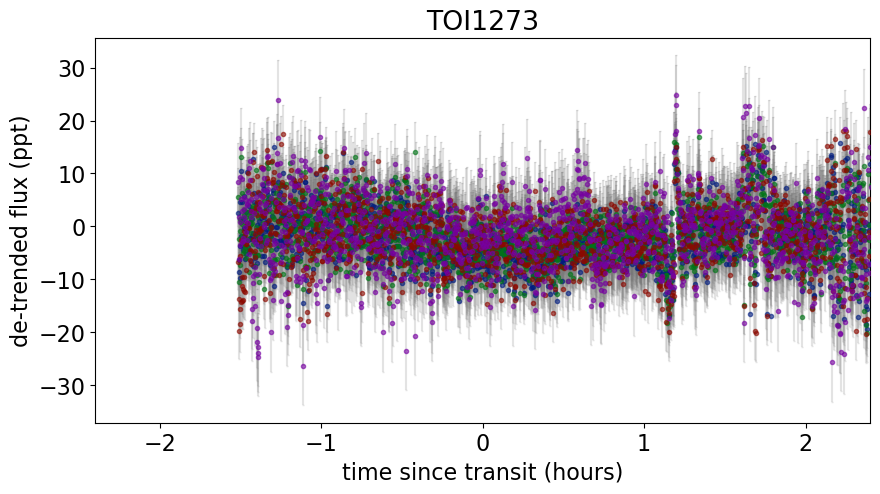

In [40]:
# Plot the folded data, con los parametros del BLS
data2_fold = (data2['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data3_fold = (data3['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data4_fold = (data4['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data5_fold = (data5['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period

muscat_time = pd.concat([data2_fold, data3_fold, data4_fold, data5_fold], ignore_index=True)
# datos finales muscat
x_muscat_zs_ = np.ascontiguousarray(data2['bjd'], dtype=np.float64)
x_muscat_g_ = np.ascontiguousarray(data3['bjd'], dtype=np.float64)
x_muscat_i_ = np.ascontiguousarray(data4['bjd'], dtype=np.float64)
x_muscat_r_ = np.ascontiguousarray(data5['bjd'], dtype=np.float64)
y_muscat_zs_ = np.ascontiguousarray(data2['flux'], dtype=np.float64)
y_muscat_g_ = np.ascontiguousarray(data3['flux'], dtype=np.float64)
y_muscat_i_ = np.ascontiguousarray(data4['flux'], dtype=np.float64)
y_muscat_r_ = np.ascontiguousarray(data5['flux'], dtype=np.float64)
yerr_muscat_zs_ = np.ascontiguousarray(data2['flux_err'], dtype=np.float64)
yerr_muscat_g_ = np.ascontiguousarray(data3['flux_err'], dtype=np.float64)
yerr_muscat_i_ = np.ascontiguousarray(data4['flux_err'], dtype=np.float64)
yerr_muscat_r_ = np.ascontiguousarray(data5['flux_err'], dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(data2_fold*24, y_muscat_zs_, '.', label='Muscat2_zs', alpha=0.6, zorder=100)
plt.errorbar(data2_fold*24, y_muscat_zs_, yerr=yerr_muscat_zs_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data3_fold*24, y_muscat_g_, '.', label='Muscat2_g', alpha=0.6, zorder=100)
plt.errorbar(data3_fold*24, y_muscat_g_, yerr=yerr_muscat_g_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data4_fold*24, y_muscat_i_, '.', label='Muscat2_i', alpha=0.6, zorder=100)
plt.errorbar(data4_fold*24, y_muscat_i_, yerr=yerr_muscat_i_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data5_fold*24, y_muscat_r_, '.', label='Muscat2_r', alpha=0.6, zorder=100)
plt.errorbar(data5_fold*24, y_muscat_r_, yerr=yerr_muscat_r_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)

plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
plt.xlim(-0.10*24, 0.10*24)
plt.title("TOI1273")
#plt.savefig('new_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')
plt.show()

In [41]:
# mask the second half of the transit?
x_muscat_zs = x_muscat_zs_[data2_fold*24<0.5]
x_muscat_g = x_muscat_g_[data3_fold*24<0.5]
x_muscat_i = x_muscat_i_[data4_fold*24<0.5]
x_muscat_r = x_muscat_r_[data5_fold*24<0.5]
y_muscat_zs = y_muscat_zs_[data2_fold*24<0.5]
y_muscat_g = y_muscat_g_[data3_fold*24<0.5]
y_muscat_i = y_muscat_i_[data4_fold*24<0.5]
y_muscat_r = y_muscat_r_[data5_fold*24<0.5]
yerr_muscat_zs = yerr_muscat_zs_[data2_fold*24<0.5]
yerr_muscat_g = yerr_muscat_g_[data3_fold*24<0.5]
yerr_muscat_i = yerr_muscat_i_[data4_fold*24<0.5]
yerr_muscat_r = yerr_muscat_r_[data5_fold*24<0.5]

print(len(x_muscat_zs), len(y_muscat_zs), len(yerr_muscat_zs))
print(len(x_muscat_g), len(y_muscat_g), len(yerr_muscat_g))
print(len(x_muscat_i), len(y_muscat_i), len(yerr_muscat_i))
print(len(x_muscat_r), len(y_muscat_r), len(yerr_muscat_r))

801 801 801
801 801 801
798 798 798
801 801 801


# LC dataset

In [42]:
from collections import OrderedDict

datasets = OrderedDict(
    [
        ("tess", [x, y, yerr, texp]),
        ("keplercam_B", [x_keplercam_B, y_keplercam_B, yerr_keplercam_B, texp_keplercam]),
        ('muscat_zs', [x_muscat_zs, y_muscat_zs, yerr_muscat_zs, texp_muscat]),
        ('muscat_g', [x_muscat_g, y_muscat_g, yerr_muscat_g, texp_muscat]),
        ('muscat_i', [x_muscat_i, y_muscat_i, yerr_muscat_i, texp_muscat]),
        ('muscat_r', [x_muscat_r, y_muscat_r, yerr_muscat_r, texp_muscat])
    ]
)

In [43]:
# print type of all arrays in datasets
for key in datasets:
    print(key, type(datasets[key][0]), type(datasets[key][1]), type(datasets[key][2]), type(datasets[key][3]))
    

tess <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'float'>
keplercam_B <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'NoneType'>
muscat_zs <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'NoneType'>
muscat_g <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'NoneType'>
muscat_i <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'NoneType'>
muscat_r <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'NoneType'>


In [44]:
0.5*np.log(bls_depth * 1e-3)

-2.812725900306335

In [225]:
K = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0)
print(K, "m/s")

[26.47708999] m/s


In [226]:
K.item()

26.477089986851546

In [229]:
np.log(0.1329)

-2.0181583132629375

# Joint model

In [47]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes 
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 3000)
phase_lc = np.linspace(-0.3, 0.3, 500)

for i in range(10):
    with pm.Model() as model:
        # Parameters for the stellar properties
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)

        # b = pmx.UnitUniform("b")
        log_ror = pm.TruncatedNormal("log_ror", mu=0.5*np.log(bls_depth * 1e-3), sd=1, upper=np.log(0.1329))
        #log_ror = pm.Normal("log_ror", mu=-2.90, sd=1)
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        b = xo.ImpactParameter("b", ror)


        logK = pm.Normal("logK", mu=np.log(K.item()), sd=2.0)
        K = pm.Deterministic("K", tt.exp(logK))
        #m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        period = pm.Deterministic("period", tt.exp(log_period))

        # comentar las proximas tres lineas para versión con e=0 fixed
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.01]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=1)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Loop over the instruments
        parameters = dict()
        lc_models = dict()
        transit_obs = dict()
        lc_pred = dict()

        for n, (name, (x_, y_, yerr_, texp_)) in enumerate(datasets.items()):
            # We define the per-instrument parameters in a submodel so that we
            # don't have to prefix the names manually
            with pm.Model(name=name, model=model):
                # The flux zero point
                mean = pm.Normal("mean", mu=0.0, sd=5.0)
                # The limb darkening
                u_star = xo.QuadLimbDark("u_star")
                star = xo.LimbDarkLightCurve(u_star)

                # Transit jitter
                logs = pm.Normal("logs", mu=np.log(np.median(yerr_)), sd=1)
                
                # Keep track of the parameters for optimization
                parameters[name] = [mean, u_star, logs]

            # The light curve model
            def lc_model(mean, star, r_pl, texp, t):
                return tt.sum((star.get_light_curve(orbit=orbit, r=r_pl, 
                                                        t=t, texp=texp)* 1e3), axis=-1) + mean

            #lc_model = partial(lc_model, mean, star, ror, texp)
            lc_models[name] = lc_model(mean, star, r_pl, texp_, x_)

            # The likelihood for the light curve
            err_lc = tt.sqrt(yerr_**2 + tt.exp(2*logs)) 
            transit_obs = pm.Normal(f"{name}_obs", mu=lc_models[name], sd=err_lc, observed=y_) 

            # # Compute and save the phased light curve models
            pm.Deterministic(f"{name}_lc_pred", 1e3 * star.get_light_curve(orbit=orbit, 
                                                                    r=r_pl, t=t0 + phase_lc, 
                                                                    texp=texp_)[..., 0],)

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref, 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)


        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv**2 + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Optimize the model
        map_soln = model.test_point
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[name])
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[name] + [logK, ecs, b, log_period])
            map_soln = pmx.optimize(map_soln, parameters[name] + [log_sigma_rv, trend])
        map_soln = pmx.optimize(map_soln)

        extras = dict()
        for name in datasets:
            extras[name] = pmx.eval_in_model(lc_models[name], map_soln)

        # Do some sigma clipping
        num = dict((name, len(datasets[name][0])) for name in datasets)
        clipped = dict()
        masks = dict()
        for name in datasets:
            mdl = pmx.eval_in_model(lc_models[name], map_soln)
            resid = datasets[name][1] - mdl
            sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
            masks[name] = np.abs(resid - np.median(resid)) < 7 * sigma
            clipped[name] = num[name] - masks[name].sum()
            print(f"Sigma clipped {clipped[name]} {name} light curve points")

        if all(c < 10 for c in clipped.values()):
            break

        else:
            for name in datasets:
                datasets[name][0] = datasets[name][0][masks[name]]
                datasets[name][1] = datasets[name][1][masks[name]]
                datasets[name][2] = datasets[name][2][masks[name]]

message: Optimization terminated successfully.
logp: -19224.127570419347 -> -18686.87329682257


message: Optimization terminated successfully.
logp: -18686.87329682257 -> -18648.669848451926


message: Optimization terminated successfully.
logp: -18648.669848451926 -> -18549.908692346973


message: Optimization terminated successfully.
logp: -18549.908692346973 -> -18413.612359152954


message: Optimization terminated successfully.
logp: -18413.612359152954 -> -18347.05698082808


message: Optimization terminated successfully.
logp: -18347.05698082808 -> -18224.486894589827


message: Desired error not necessarily achieved due to precision loss.
logp: -18224.486894589827 -> -17288.475749983394


message: Optimization terminated successfully.
logp: -17288.475749983394 -> -17230.80212150914


message: Desired error not necessarily achieved due to precision loss.
logp: -17230.802121509143 -> -17167.24305592956


message: Desired error not necessarily achieved due to precision loss.
logp: -17167.24305592956 -> -17159.90007562337


message: Desired error not necessarily achieved due to precision loss.
logp: -17159.900075623373 -> -17148.462942799506


message: Desired error not necessarily achieved due to precision loss.
logp: -17148.462942799506 -> -17148.39022386437


message: Desired error not necessarily achieved due to precision loss.
logp: -17148.390223864375 -> -17141.159926763816


message: Desired error not necessarily achieved due to precision loss.
logp: -17141.159926763816 -> -17141.15808384697


message: Desired error not necessarily achieved due to precision loss.
logp: -17141.158083846974 -> -17136.1100285437


message: Desired error not necessarily achieved due to precision loss.
logp: -17136.1100285437 -> -17136.10805597336


message: Desired error not necessarily achieved due to precision loss.
logp: -17136.10805597336 -> -17133.4078103459


message: Optimization terminated successfully.
logp: -17133.4078103459 -> -17133.39977033022
optimizing logp for variables: [muscat_r_logs, muscat_r_u_star, muscat_r_mean, muscat_i_logs, muscat_i_u_star, muscat_i_mean, muscat_g_logs, muscat_g_u_star, muscat_g_mean, muscat_zs_logs, muscat_zs_u_star, muscat_zs_mean, keplercam_B_logs, keplercam_B_u_star, keplercam_B_mean, tess_logs, tess_u_star, tess_mean, trend, log_sigma_rv, ecs, logK, b, log_ror, log_period, t0, r_star, m_star]


message: Desired error not necessarily achieved due to precision loss.
logp: -17133.399770330223 -> -16641.581628806543


Sigma clipped 1 tess light curve points
Sigma clipped 0 keplercam_B light curve points
Sigma clipped 0 muscat_zs light curve points
Sigma clipped 0 muscat_g light curve points
Sigma clipped 0 muscat_i light curve points
Sigma clipped 0 muscat_r light curve points


MAP rv model

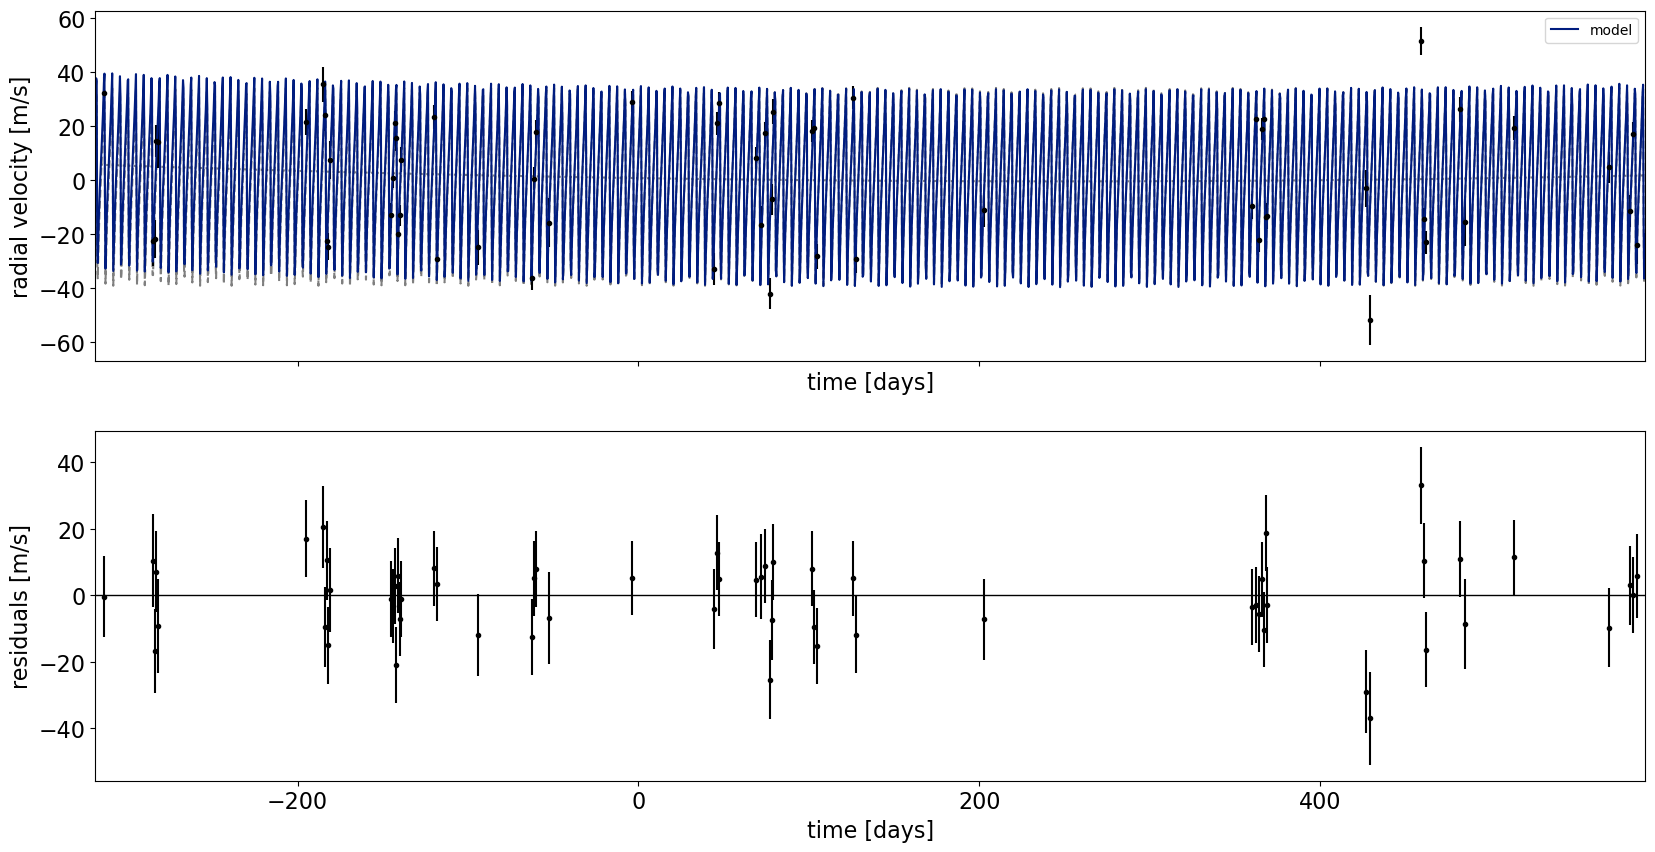

In [48]:
# We plot the initial model:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln['vrad_pred'], "--k", alpha=0.5)
    ax.plot(t_rv, soln['bkg_pred'], ":k", alpha=0.5)
    ax.plot(t_rv, soln['rv_model_pred'], label="model")
    ax.legend(fontsize=10)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2 + np.exp(2 * soln["log_sigma_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    #ax.set_xlim(2200,2300)
    ax.set_xlabel("time [days]")

_ = plot_rv_curve(map_soln)

MAP LCs models

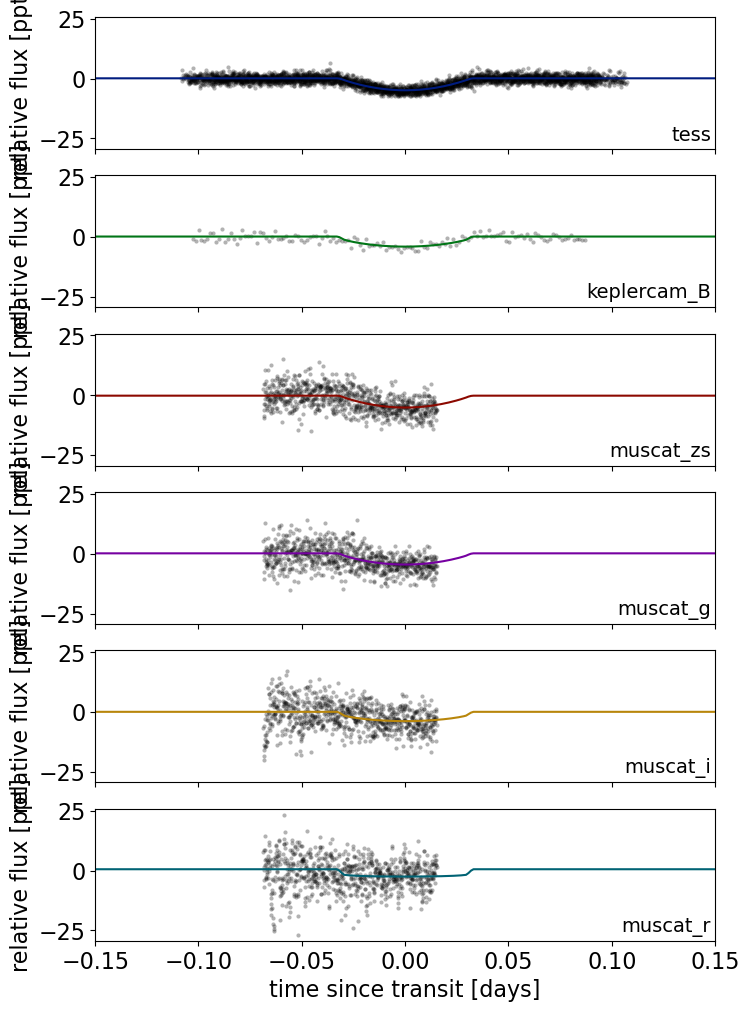

In [49]:
fig, axes = plt.subplots(6, sharex=True, sharey=True, figsize=(8, 12))

for n, name in enumerate(datasets):
    ax = axes[n]

    x, y = datasets[name][:2]

    period = map_soln["period"]
    folded = (x - map_soln["t0"] + 0.5 * period) % period - 0.5 * period
    m = np.abs(folded) < 0.2
    ax.plot(
        folded[m],
        (y  - map_soln[f"{name}_mean"])[m],
        ".k",
        alpha=0.3,
        mec="none",
    )
    ax.plot(
        phase_lc, map_soln[name+'_lc_pred'] + map_soln[f"{name}_mean"], f"C{n}", label=name
    ) # SUMAR EL MEAN?
    ax.annotate(
        name,
        xy=(1, 0),
        xycoords="axes fraction",
        va="bottom",
        ha="right",
        xytext=(-3, 3),
        textcoords="offset points",
        fontsize=14,
    )

axes[-1].set_xlim(-0.15, 0.15)
axes[-1].set_xlabel("time since transit [days]")
for ax in axes:
    ax.set_ylabel("relative flux [ppt]")

#plt.savefig('lcs_fits.png', dpi=200, bbox_inches='tight')

In [50]:
# pm.model_to_graphviz(model)

# Sampling

In [55]:
import multiprocessing

with model:
    trace = pmx.sample(
        tune=4000, #2500,
        draws=4000, #2000,
        start=map_soln,
        cores=2, #4
        chains=2, #4
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[203771098, 203775000],#, 261136679, 261136680],
        init="adapt_full",
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [muscat_r_logs, muscat_r_u_star, muscat_r_mean, muscat_i_logs, muscat_i_u_star, muscat_i_mean, muscat_g_logs, muscat_g_u_star, muscat_g_mean, muscat_zs_logs, muscat_zs_u_star, muscat_zs_mean, keplercam_B_logs, keplercam_B_u_star, keplercam_B_mean, tess_logs, tess_u_star, tess_mean, trend, log_sigma_rv, ecs, logK, b, log_ror, log_period, t0, r_star, m_star]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 11055 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [51]:
import arviz as az
# version con e libre
# az.to_netcdf(trace, 'trace.toi1273_glcs_1radio_constraint_prior.save')
# az.to_netcdf(trace, 'trace.toi1273_glcs_1radio_conK.save')
trace = az.from_netcdf('trace.toi1273_glcs_1radio_conK.save')
#trace = az.from_netcdf('trace.toi1273.save') #version sin glcs
#trace = az.from_netcdf('trace.toi1273_glcs_1radio_2.save')
#trace = az.from_netcdf('trace.toi1273_glcs_1radio_constraint_prior.save')

# version con e=0 fixed
# az.to_netcdf(trace, 'trace.toi1273_noecc.save')
# trace = az.from_netcdf('trace.toi1273_noecc.save')

In [52]:
#trace.posterior.data_vars
# print only the names
#trace=trace_
for n, var in enumerate(trace.posterior.data_vars):
    if n>15:
        print(n, var)

16 muscat_r_logs
17 m_star
18 r_star
19 log_ror
20 ror
21 r_pl
22 b
23 K
24 period
25 ecs
26 ecc
27 omega
28 tess_u_star
29 tess_lc_pred
30 keplercam_B_u_star
31 keplercam_B_lc_pred
32 muscat_zs_u_star
33 muscat_zs_lc_pred
34 muscat_g_u_star
35 muscat_g_lc_pred
36 muscat_i_u_star
37 muscat_i_lc_pred
38 muscat_r_u_star
39 muscat_r_lc_pred
40 vrad
41 bkg
42 rv_model
43 vrad_pred
44 bkg_pred
45 rv_model_pred


Summary stats

In [53]:
summary= az.summary(trace, stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.68, round_to=6,
           var_names=[
               't0',
               'logK',
               'log_period',
               'log_ror',
               'log_sigma_rv',
               'trend',
               'tess_mean',
               'tess_logs',
               'keplercam_B_mean',
               'keplercam_B_logs',
               'muscat_zs_mean',
               'muscat_zs_logs',
               'muscat_g_mean',
               'muscat_g_logs',
               'muscat_i_mean',
               'muscat_i_logs',
               'muscat_r_mean',
               'muscat_r_logs',
               'm_star',
               'r_star',
               'ror',
               'r_pl',
               'b',
               'K',
               'period',
               'ecs',
               'ecc',
               'omega',
               'tess_u_star',
               'keplercam_B_u_star',
               'muscat_zs_u_star',
               'muscat_g_u_star',
               'muscat_i_u_star',
               'muscat_r_u_star',
           ])

In [54]:
print(summary.ess_bulk.mean())
print(summary.ess_tail.mean())

7549.52679316279
4734.919474627907


In [55]:
summary

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0,-489.090324,0.000481,-489.090774,-489.089827,0.000005,0.000003,10810.926273,5572.805897,1.000749,-489.090325,0.000481
logK,3.286289,0.058087,3.232649,3.345054,0.000595,0.000421,9694.734656,5809.415108,1.000425,3.287054,0.058084
log_period,1.532837,0.000001,1.532836,1.532838,0.000000,0.000000,12201.407531,6348.571283,1.000261,1.532837,0.000001
log_ror,-2.303715,0.116850,-2.455941,-2.219915,0.002505,0.001772,1989.947033,959.251731,1.000156,-2.316207,0.116843
log_sigma_rv,2.001889,0.153033,1.859699,2.157977,0.001906,0.001348,6690.568505,3682.038641,1.000049,2.006668,0.153023
trend[0],0.000010,0.000015,-0.000004,0.000025,0.000000,0.000000,8058.356108,4236.874307,0.999989,0.000010,0.000015
trend[1],-0.002849,0.004561,-0.007209,0.001692,0.000043,0.000048,11119.934734,5408.825113,1.003168,-0.002862,0.004560
trend[2],0.033763,0.897739,-0.815640,0.953859,0.008604,0.012394,10848.230774,5199.562672,1.000022,0.028399,0.897683
tess_mean,0.096738,0.030431,0.067864,0.127893,0.000300,0.000223,10290.301013,6229.326448,0.999865,0.097170,0.030429
tess_logs,-2.252402,0.443519,-2.605761,-1.762133,0.005353,0.004202,8980.815424,4048.838538,1.000604,-2.197136,0.443491


array([<Axes: title={'center': 'r_pl'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'ecc'}>], dtype=object)

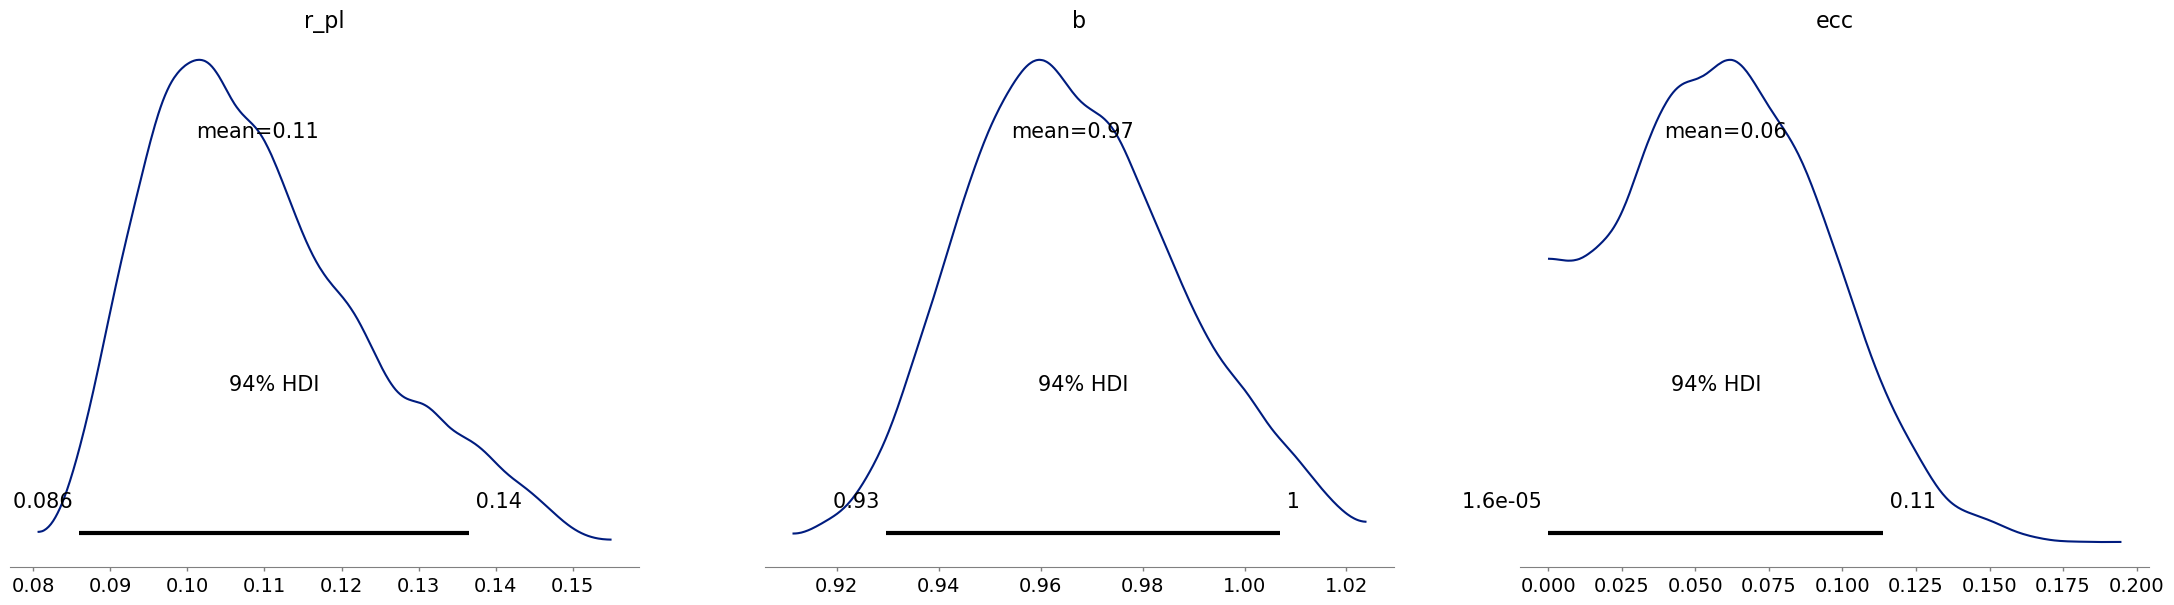

In [56]:
az.plot_posterior(trace, var_names=['r_pl', 'b', 'ecc'])
#plt.savefig('posterior.png', dpi=300, bbox_inches='tight')

In [57]:
from uncertainties import ufloat
from uncertainties.umath import *

logsigma_rv_mean = trace.posterior["log_sigma_rv"].mean().item()
logsigma_rv = ufloat(logsigma_rv_mean, trace.posterior["log_sigma_rv"].std().item())
rv_jitter_ = np.e**logsigma_rv
# tess_jitter_median = trace.posterior['logs'].median().item()
# tess_jitter = ufloat(tess_jitter_median, trace.posterior['logs'].std().item())
# tess_jitter_val = np.e**tess_jitter
tess_jitter_median = trace.posterior['tess_logs'].median().item()
tess_jitter = ufloat(tess_jitter_median, trace.posterior['tess_logs'].std().item())
tess_jitter_val = np.e**tess_jitter
keplercam_B_jitter_median = trace.posterior['keplercam_B_logs'].median().item()
keplercam_B_jitter = ufloat(keplercam_B_jitter_median, trace.posterior['keplercam_B_logs'].std().item())
keplercam_B_jitter_val = np.e**keplercam_B_jitter
muscat_zs_jitter_median = trace.posterior['muscat_zs_logs'].median().item()
muscat_zs_jitter = ufloat(muscat_zs_jitter_median, trace.posterior['muscat_zs_logs'].std().item())
muscat_zs_jitter_val = np.e**muscat_zs_jitter
# same for g, i, r
muscat_g_jitter_median = trace.posterior['muscat_g_logs'].median().item()
muscat_g_jitter = ufloat(muscat_g_jitter_median, trace.posterior['muscat_g_logs'].std().item())
muscat_g_jitter_val = np.e**muscat_g_jitter
muscat_i_jitter_median = trace.posterior['muscat_i_logs'].median().item()
muscat_i_jitter = ufloat(muscat_i_jitter_median, trace.posterior['muscat_i_logs'].std().item())
muscat_i_jitter_val = np.e**muscat_i_jitter
muscat_r_jitter_median = trace.posterior['muscat_r_logs'].median().item()
muscat_r_jitter = ufloat(muscat_r_jitter_median, trace.posterior['muscat_r_logs'].std().item())
muscat_r_jitter_val = np.e**muscat_r_jitter
print("RV jitter = ", rv_jitter_)
print("TESS jitter = ", tess_jitter_val)
print("Keplercam B jitter = ", keplercam_B_jitter_val)
print("Muscat zs jitter = ", muscat_zs_jitter_val)
print("Muscat g jitter = ", muscat_g_jitter_val)
print("Muscat i jitter = ", muscat_i_jitter_val)
print("Muscat r jitter = ", muscat_r_jitter_val)

RV jitter =  7.4+/-1.1
TESS jitter =  0.11+/-0.05
Keplercam B jitter =  0.81+/-0.17
Muscat zs jitter =  0.46+/-0.21
Muscat g jitter =  0.45+/-0.20
Muscat i jitter =  1.2+/-0.5
Muscat r jitter =  0.8+/-0.4


Parámetros

In [58]:
import math
radio = ufloat((trace.posterior["r_pl"].median().item()*u.R_sun).to(u.R_jup).value, (trace.posterior["r_pl"].std().item()*u.R_sun).to(u.R_jup).value)
b = ufloat(trace.posterior["b"].median().item(), trace.posterior["b"].std().item())
K = ufloat(trace.posterior["K"].median().item(), trace.posterior["K"].std().item())
eccen = ufloat(trace.posterior["ecc"].median().item(), trace.posterior["ecc"].std().item())
omega = ufloat(trace.posterior["omega"].median().item(), trace.posterior["omega"].std().item())
periodo = ufloat(trace.posterior['period'].median().item()*u.day.to(u.second),trace.posterior['period'].std().item()*u.day.to(u.second))
t_0 = ufloat(trace.posterior['t0'].median().item()+ref_time, trace.posterior['t0'].std().item())
G = 6.6743e-11
teff = ufloat(5697,62)
mstar = ufloat(trace.posterior['m_star'].median().item()*u.M_sun.to(u.kg), trace.posterior['m_star'].std().item()*u.M_sun.to(u.kg))
rstar = ufloat(trace.posterior['r_star'].median().item()*u.R_sun.to(u.au), trace.posterior['r_star'].std().item()*u.R_sun.to(u.au))
#msini = (periodo*u.day.to(u.second)*mstar/(2*np.pi*G))**(1/3)*K*np.sqrt(1-eccen**2)
msini = K*sqrt(1-eccen**2)*(periodo*mstar**2/(2*np.pi*G))**(1/3)*u.kg.to(u.M_jup)
smaxis = (periodo**2*G*(mstar+msini)/(4*np.pi**2))**(1/3)*u.m.to(u.au)
teq = teff*(rstar/smaxis)**(1/2)*(1/4)**(1/4)
densidad = msini*u.M_jup.to(u.g) * 1/(4 / 3 * np.pi * (radio*u.R_jup.to(u.cm))**3)
print("Rp = {r:.3f} Rj".format(r=radio))
print("b = {b:.3f}".format(b=b))
print("e = {e:.6f}".format(e=eccen))
print("omega = {w:.6f}".format(w=omega))
print("P = {p:.6f} days".format(p=periodo*u.second.to(u.day)))
print("Epoca = {e:.5f}".format(e=t_0))
print('a = {s:.4f} au'.format(s=smaxis))
print('Teq = {t:.3f} K'.format(t=teq))
print('m_pl = {m:.3f} Mj'.format(m=msini))
print('K = {k:.3f} m/s'.format(k=K))
print('densidad = {d:.3f} g/cm^3'.format(d=densidad))

Rp = 1.040+/-0.137 Rj
b = 0.965+/-0.021
e = 0.059274+/-0.033200
omega = 2.167830+/-2.149995
P = 4.631298+/-0.000003 days
Epoca = 1712.34655+/-0.00048
a = 0.0540+/-0.0004 au
Teq = 1231.315+/-20.854 K
m_pl = 0.216+/-0.013 Mj
K = 26.764+/-1.549 m/s
densidad = 0.238+/-0.095 g/cm^3


Traceplot

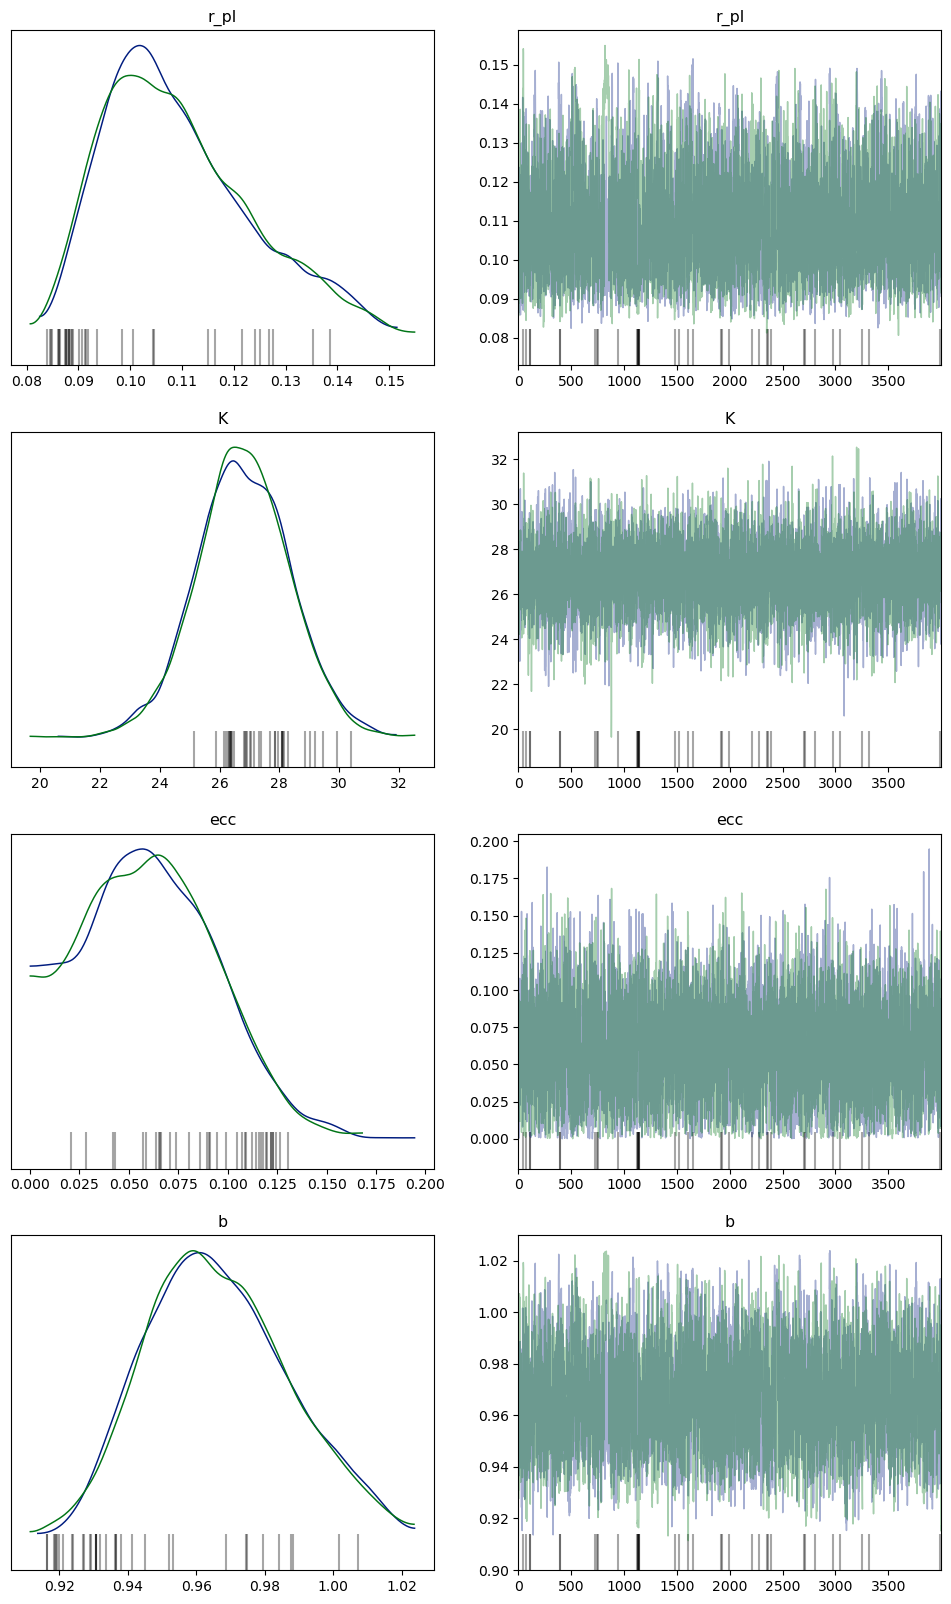

In [59]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag

_ = az.plot_trace(trace, var_names=['r_pl', 'K','ecc', 'b'] #log_depth or log_ror
                                    , compact=False, figsize=(12,20)) # SAMPLED 1 #ror instead of log_depth
# _ = az.plot_trace(trace, var_names=['log_period', 'log_m_pl', 't0', 'r_star', 'm_star']
#                                    , compact=False, figsize=(12,20)) # SAMPLED 2
# _ = az.plot_trace(trace, var_names=['ecs', 'b', 'u_star', 'mean']
#                                    , compact=False, figsize=(12,25)) # SAMPLED 3
# plt.savefig('trace_joint_1199_1.png',dpi=200,bbox_inches='tight')

In [60]:
trace3 = trace.copy()
trace3.posterior['r_pl'] = trace3.posterior['r_pl']*9.73116

In [61]:
CORNER_KWARGS = dict(
    smooth=0.9,
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.16,0.5,0.84),
    max_n_ticks=3
)

<Figure size 1400x1400 with 0 Axes>

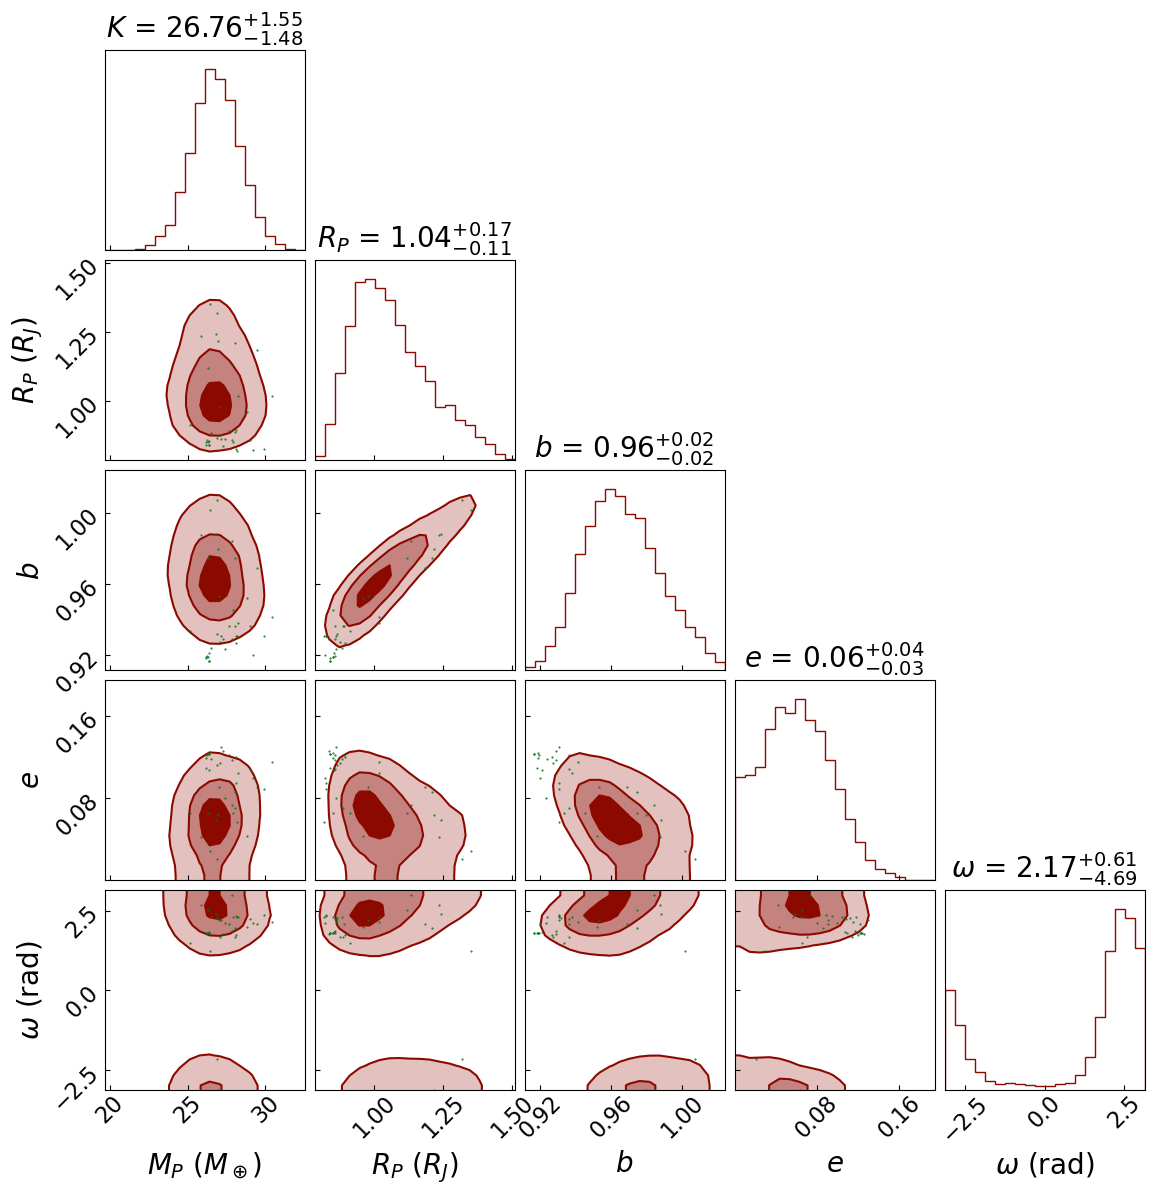

In [62]:
from cProfile import label
import corner
plt.figure(figsize=(14,14))
figure = corner.corner(trace3, var_names=['K', 'r_pl', 'b', 'ecc', 'omega'],#, 'omega'], 
                        labels=[r"$M_P ~(M_\oplus)$", r"$R_P ~(R_{J})$", r"$b$", r"$e$", r"$\omega$ (rad)"], label_kwargs={'fontsize':20},#, r"$\omega$ (rad)"],
                        show_titles=True, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['$K$','$R_P$','$b$','$e$', '$\omega$'], divergences=True, plot_contours=True,
                        labelpad=0, color='C2', **CORNER_KWARGS) #, quantiles=[0.16, 0.5, 0.84],
for ax in figure.get_axes():
    ax.tick_params(axis='both', pad=1, direction='in', labelbottom=True, labelleft=True, left=True, bottom=True)
#plt.savefig('corner_1199_paper.png',dpi=300,bbox_inches='tight', facecolor='w')
plt.show()

## LC Phase plot

In [63]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Get the posterior median orbital parameters
p_ = np.median(flat_samps["period"])
t0_ = np.median(flat_samps["t0"])
tess_mean = np.median(flat_samps["tess_mean"])
keplercam_B_mean = np.median(flat_samps["keplercam_B_mean"])
muscat_zs_mean = np.median(flat_samps["muscat_zs_mean"])
muscat_r_mean = np.median(flat_samps["muscat_r_mean"])
muscat_g_mean = np.median(flat_samps["muscat_g_mean"])
muscat_i_mean = np.median(flat_samps["muscat_i_mean"])

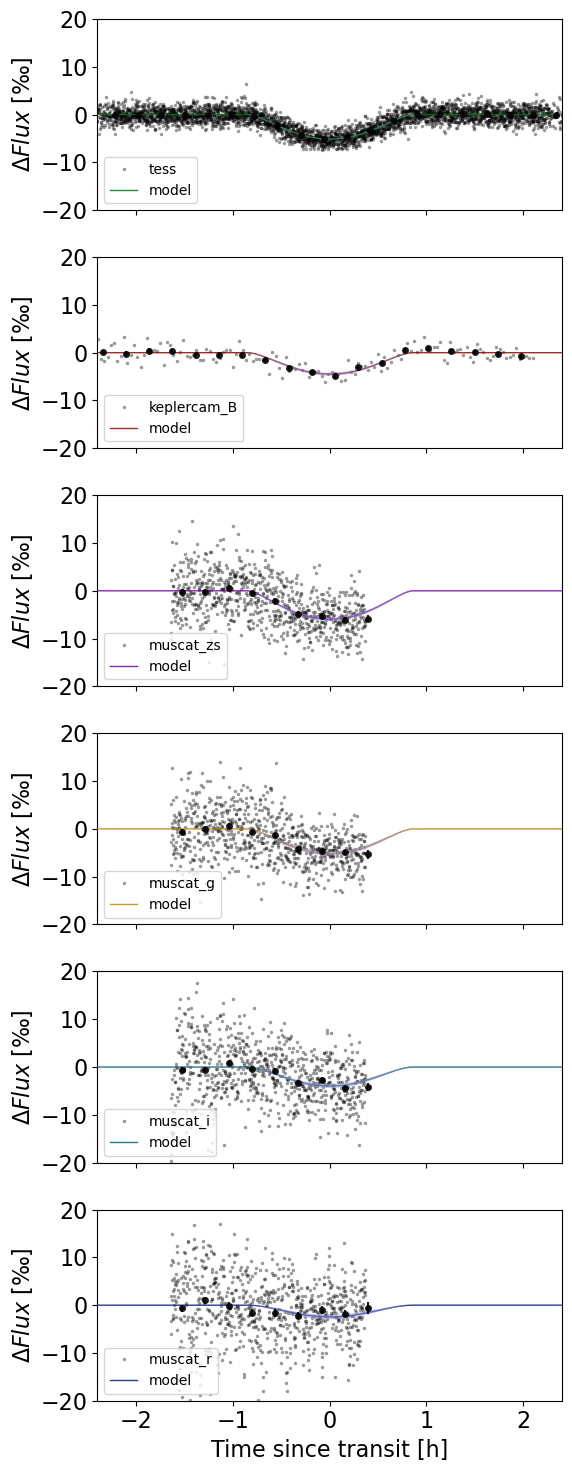

In [64]:
fig, axes = plt.subplots(6, sharex=True, sharey=True, figsize=(6, 15))

for n, name in enumerate(datasets):
    ax = axes[n]

    # plot the folded transits
    x, y, yerr = datasets[name][:3]
    folded = (x - t0_ + 0.5 * p_) % p_ - 0.5 * p_
    mean = np.median(flat_samps[f"{name}_mean"])
    ax.plot(folded*24, (y  - mean), ".k", alpha=0.4, label=f"{name}", mec="none", ms=5)
    # ax.annotate(
    #     name,
    #     xy=(1, 0),
    #     xycoords="axes fraction",
    #     va="bottom",
    #     ha="right",
    #     xytext=(-3, 3),
    #     textcoords="offset points",
    #     fontsize=14,
    # )
    # Overplot the phase binned light curve with rmse as error bars
    lcc = lk.LightCurve(time=folded, flux=y - mean, flux_err=yerr)
    lcc_binned = lcc.bin(time_bin_size=0.01)
    ax.errorbar(lcc_binned['time'].value*24, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
                 ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.9, zorder=900)
    # overplot the model
    pred = np.percentile(flat_samps[f"{name}_lc_pred"], [16, 50, 84], axis=-1)
    ax.plot(phase_lc*24, pred[1], color=f"C{n+1}", label="model", zorder=800, linewidth=1, alpha=0.85)
    art = ax.fill_between(phase_lc*24, pred[0], pred[2], color="#988ED5", alpha=0.5, zorder=800)
    art.set_edgecolor("none")
    ax.legend(fontsize=10, loc=3)

axes[-1].set_xlim(-0.10*24, 0.10*24)
axes[-1].set_xlabel("Time since transit [h]")
axes[-1].set_ylim(-20, 20)
for ax in axes:
    ax.set_ylabel(u'$\Delta Flux$ [‰]')

plt.tight_layout()
#plt.savefig('1273_lcs_fits.png', dpi=300, bbox_inches='tight')

## RV Phase plot

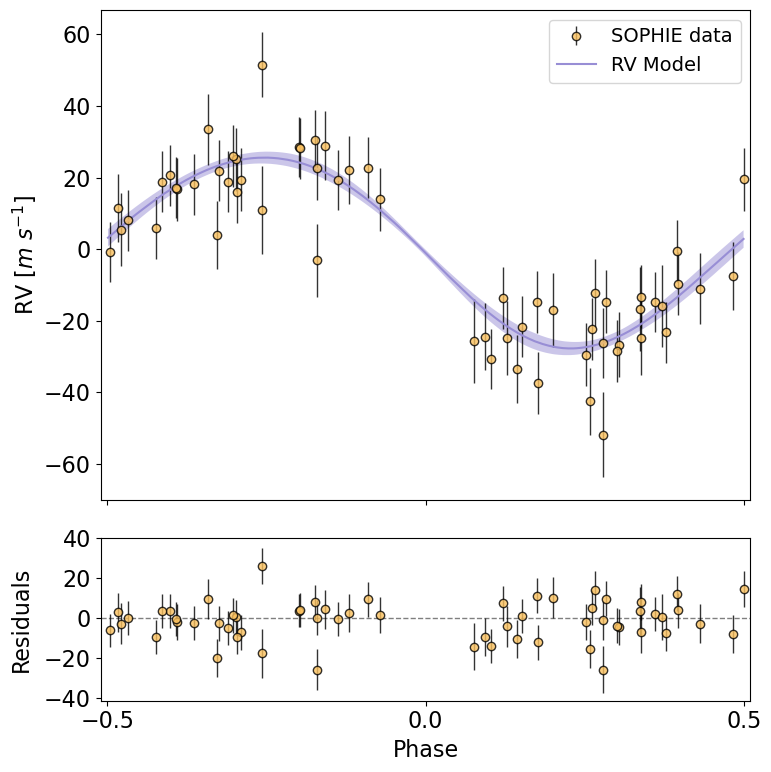

In [65]:
rv_jitter = np.exp(np.median(flat_samps['log_sigma_rv']))
bkg_ = np.median(flat_samps['bkg'].values, axis=-1)
rv_model_ = np.median(flat_samps['rv_model'].values, axis=-1)

# Plot the folded data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3,1]})
x_fold = (x_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
ax1.errorbar(x_fold/p_, y_rv - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='#FBC15E', 
            markeredgecolor='k', ecolor='k', elinewidth=1, label='SOPHIE data', alpha=0.8)

# Compute the posterior prediction for the folded RV model 
t_fold = (t_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
inds = np.argsort(t_fold)
pred = np.percentile(trace.posterior["vrad_pred"].values[:, :, inds],[16, 50, 84],axis=(0, 1),)
ax1.plot(t_fold[inds]/p_, pred[1], color="#988ED5", label="RV Model")
art = ax1.fill_between(t_fold[inds]/p_, pred[0], pred[2], color="#988ED5", alpha=0.5)
art.set_edgecolor("none")

ax1.set_xlim(-0.51, 0.51)
ax1.set_ylabel("RV [$m~s^{-1}$]")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], fontsize=14, loc='best')

# Plot the folded residuals
ax2.axhline(y=0, ls='--', color='k', linewidth=1, alpha=0.5)
ax2.errorbar(x_fold/p_, y_rv-rv_model_-bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='#FBC15E',
            markeredgecolor='k', ecolor='k', elinewidth=1, alpha=0.8, label='residuals')
ax2.set_ylabel('Residuals', labelpad=8)
ax2.set_xlabel("Phase")
ax2.set_xlim(-0.51, 0.51)
ax2.set_xticks([-0.5, 0, 0.5])
ax2.set_yticks([-40,-20, 0, 20, 40])
plt.tight_layout()
#plt.savefig('1273_rvs_fit.png', dpi=300, bbox_inches='tight', facecolor='white')

### Periodograms with residues

In [66]:
ls_res = LombScargle(data.bjd, y_rv-rv_model_-bkg_)
frequency_res, power_res = ls_res.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)
faps_res = ls_res.false_alarm_level(probabilities)  

/tmp/ipykernel_4758/130740149.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([0.2,0.4,0.6,0.8,1.0])


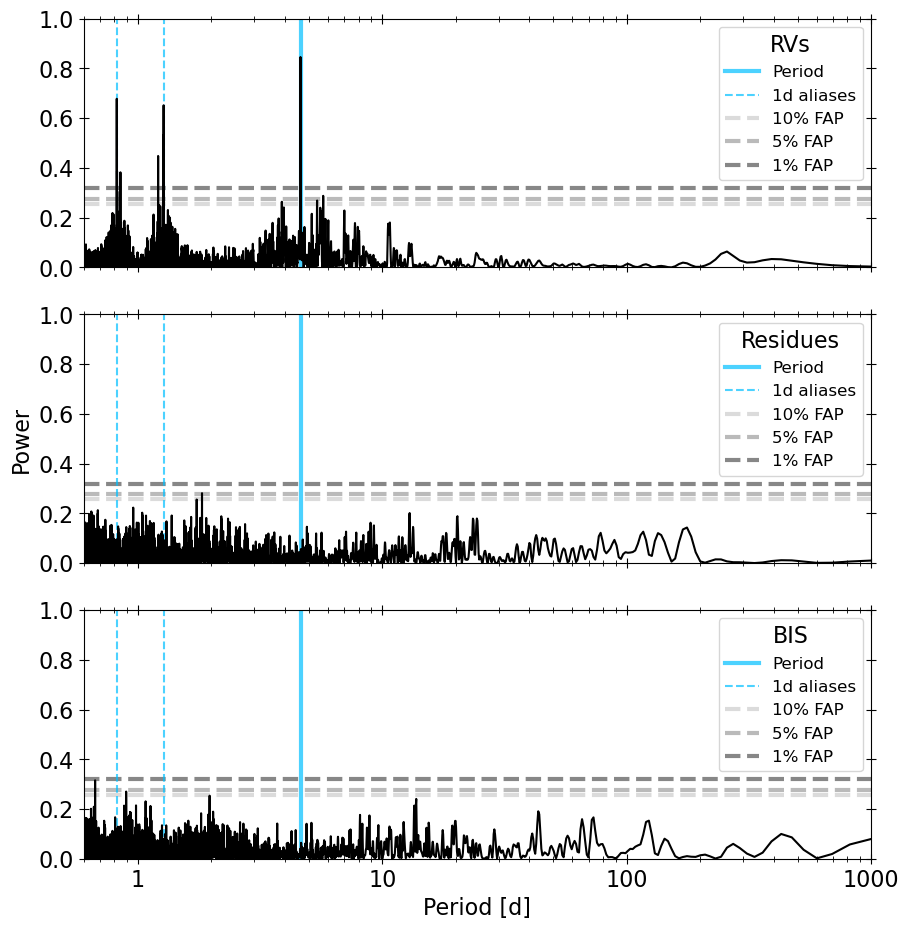

In [67]:
from matplotlib.ticker import ScalarFormatter
# plot two figures in a column
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 10), tight_layout=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)
axes[0].plot(1/frequency, power, color='k', lw=1.5, zorder=10) 
axes[1].plot(1/frequency_res, power_res, color='k', lw=1.5, zorder=10)
axes[2].plot(1/frequency_bis, power_bis, color='k', lw=1.5, zorder=10) 

# plot the 'bls_period' as a vertical line behind the plot and show in legend
axes[0].axvline(bls_period, ls='-', lw=3, alpha=0.7, color='deepskyblue', label='Period', zorder=-10)
axes[1].axvline(bls_period, ls='-', lw=3, alpha=0.7, color='deepskyblue', label='Period', zorder=-10)
axes[2].axvline(bls_period, ls='-', lw=3, alpha=0.7, color='deepskyblue', label='Period', zorder=-10)

# add the aliases as red dashed vertical lines
for i in range(3):
    axes[i].axvline(aliases[0], lw=1.5, alpha=0.7, ls='--', color='deepskyblue', label='1d aliases')
    axes[i].axvline(aliases[2], lw=1.5, alpha=0.7, ls='--', color='deepskyblue')

# overplot the false alarm probabilities
names2 = [faps, faps_res, faps_bis]
for i, names in enumerate(names2):
    axes[i].axhline(names[0], ls='--', lw=3, alpha=0.8, color='lightgray', label='10% FAP', zorder=-20)
    axes[i].axhline(names[1], ls='--', lw=3, alpha=0.8, color='darkgray', label='5% FAP', zorder=-20)
    axes[i].axhline(names[2], ls='--', lw=3, alpha=0.8, color='dimgray', label='1% FAP', zorder=-20)

axes[0].set_xlim(0.6, 1000)
axes[0].set_ylim(0, 1.0)
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')

axes[0].set_xticklabels([0.2,0.4,0.6,0.8,1.0])
# set legends for all plots in the top right corner
axes[0].legend(loc='upper right', fontsize=12)
axes[1].legend(loc='upper right', fontsize=12)
axes[2].legend(loc='upper right', fontsize=12)
# add legend title
axes[0].legend(loc='upper right', fontsize=12, title='RVs')
axes[1].legend(loc='upper right', fontsize=12, title='Residues')
axes[2].legend(loc='upper right', fontsize=12, title='BIS')
axes[0].tick_params(axis='both', which='major', size=7, top=True, right=True, direction='inout')
axes[1].tick_params(axis='both', which='major', size=7, top=True, right=True, direction='inout')
axes[2].tick_params(axis='both', which='major', size=7, top=True, right=True, direction='inout')
axes[0].tick_params(axis='both', which='minor', size=5, top=True, right=True, direction='inout')
axes[1].tick_params(axis='both', which='minor', size=5, top=True, right=True, direction='inout')
axes[2].tick_params(axis='both', which='minor', size=5, top=True, right=True, direction='inout')

formatter = ScalarFormatter()
axes[0].xaxis.set_major_formatter(formatter)
axes[1].xaxis.set_major_formatter(formatter)
axes[2].xaxis.set_major_formatter(formatter)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Period [d]")
plt.ylabel("Power")
#plt.savefig('periodograms_1273.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Aditional LCs

ASP 

In [155]:
asp = pd.read_table('data/photom/TOI1273/ASP/TIC445859771-01_UT20200121_Acton-Sky-Portal-0.36m_rp_measurements.txt')
# rp filter

In [156]:
asp['flux'] = ((asp['rel_flux_T1']/(asp['rel_flux_T1'].median())))*1e3
asp['flux_err'] = ((asp['rel_flux_err_T1']/(asp['rel_flux_T1'].median())))*1e3
asp['time'] = asp['BJD_TDB']-2457000-ref_time

In [157]:
#puntos?
print('puntos:', len(asp))
# texp?
print('texp:', np.median(np.diff(asp['BJD_TDB']))*24*60*60)

puntos: 1006
texp: 15.724799036979675


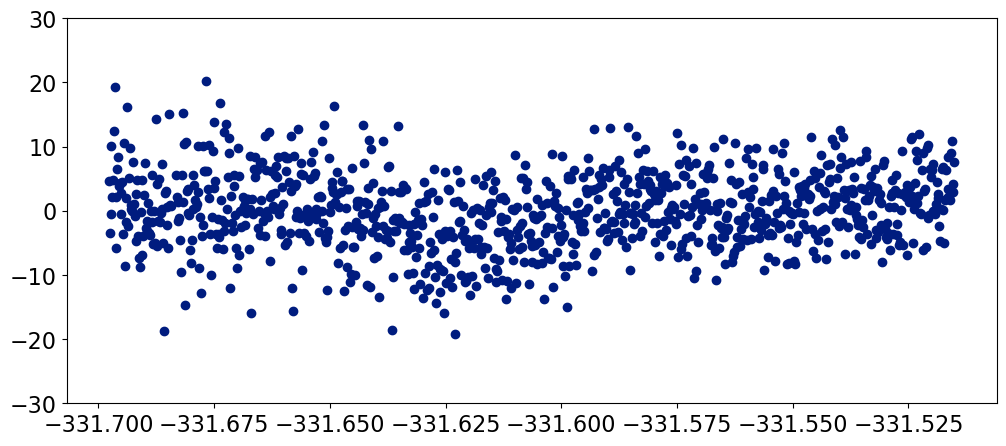

In [158]:
plt.subplots(figsize=(12,5))
plt.plot(asp['time'], (asp['flux']-1e3), 'o', label='asp')
plt.ylim(-30, 30)
plt.show()

CATANIA

In [159]:
cat = pd.read_table('./data/photom/TOI1273/CATANIA/TIC445859771-01_20200217_CT-Astroph-Obs-91cm_B_measurements.tbl')

In [160]:
cat['flux'] = cat['rel_flux_T1_n']*1e3
cat['flux_err'] = cat['rel_flux_err_T1_n']*1e3
cat['time'] = cat['BJD_TDB']-2457000-ref_time

In [161]:
print('puntos:', len(cat))
# texp?
print('texp:', np.median(np.diff(cat['BJD_TDB']))*24*60*60)

puntos: 155
texp: 69.9840098619461


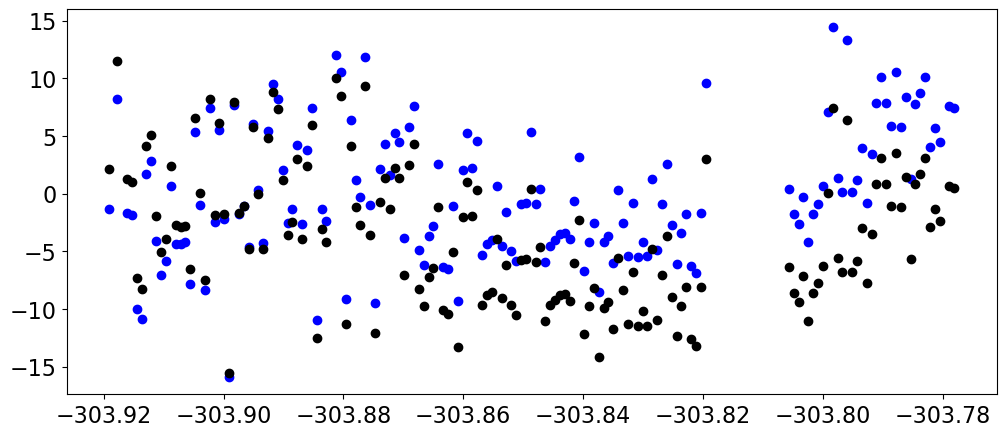

In [162]:
plt.subplots(figsize=(12,5))
plt.plot(cat['time'], cat['flux']-1e3, 'o', color='b', label='cat')
plt.plot(cat['time'], cat['rel_flux_T1_dfn']*1e3-1e3, 'o', color='k', label='cat')
#plt.ylim(-30, 30)
plt.show()

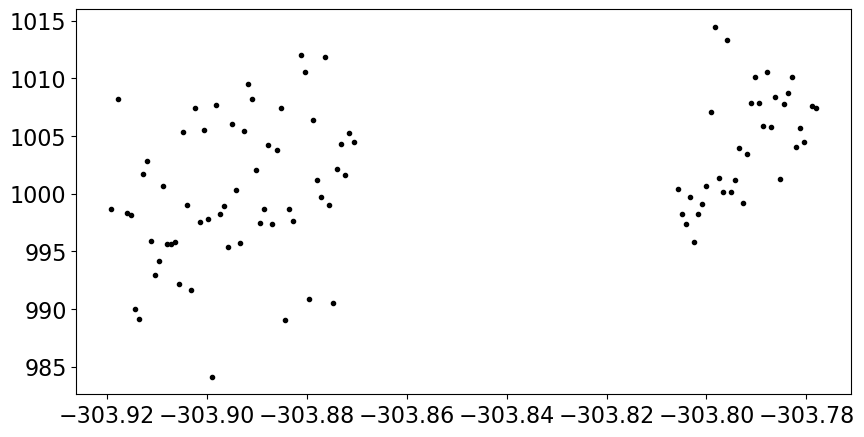

In [163]:
oot_1 = bls.transit_mask(cat['time'], bls_period, bls_duration, bls_t0)
plt.figure(figsize=(10, 5))
plt.plot(cat['time'][~oot_1], cat['flux'][~oot_1], ".k", label="data1")


In [164]:
z1 = np.polyfit(cat['time'][~oot_1], cat['flux'][~oot_1], 2) 
def pol1(x):
    return np.asarray(z1[0]*x**2 +z1[1]*x + z1[2])

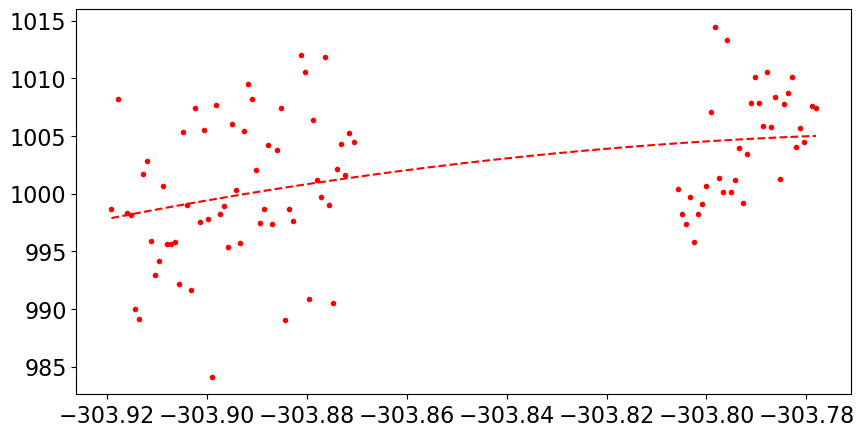

In [165]:
plt.figure(figsize=(10, 5))
plt.plot(cat['time'][~oot_1], cat['flux'][~oot_1], ".r")
x_plot1 = np.linspace(np.min(cat['time'][~oot_1]), np.max(cat['time'][~oot_1]), 1000)
plt.plot(x_plot1, pol1(x_plot1), color="r", linestyle="--")

In [166]:
cat['flux_detrended'] = np.asarray(((cat['flux'])/pol1(cat['time'])-1)*1e3)


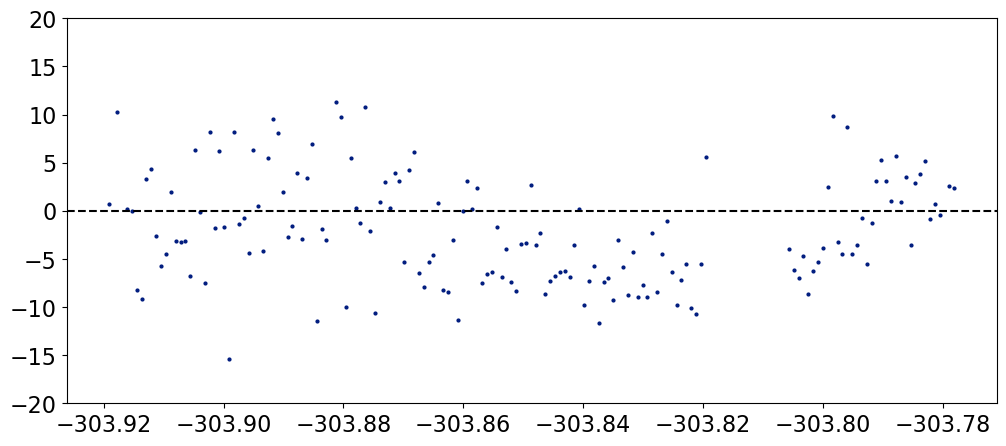

In [167]:
plt.subplots(figsize=(12,5))
plt.plot(cat['time'], cat['flux_detrended'], 'o', ms=2, label='cat')
# line at 0
plt.axhline(y=0, color='k', linestyle='--')
plt.ylim(-20,20)
plt.show()

In [168]:
from scipy.stats import binned_statistic
asd = binned_statistic(cat['time'], cat['flux_detrended'], bins=len(cat)/2)
asd_time = binned_statistic(cat['time'], cat['time'], bins=len(cat)/2)
len(asd_time[0])

77

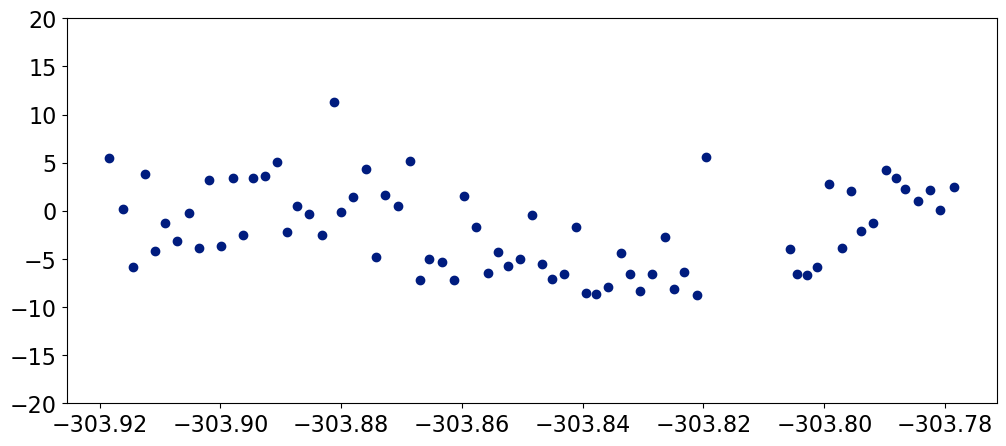

In [169]:
plt.subplots(figsize=(12,5))
plt.plot(asd_time[0], asd[0], 'o', label='cat')
plt.ylim(-20,20)
plt.show()

## Extra LCs Phase plot

In [170]:
datasets.keys()

odict_keys(['tess', 'keplercam_B', 'muscat_zs', 'muscat_g', 'muscat_i', 'muscat_r'])

In [175]:
extra_datasets = OrderedDict(
    [
        ("ASP", [asp['time'], asp['flux']-1e3, asp['flux_err']]),
        ("CATANIA", [cat['time'], cat['flux_detrended'], cat['flux_err']])
    ]
)

# asp es rp
# cat es B

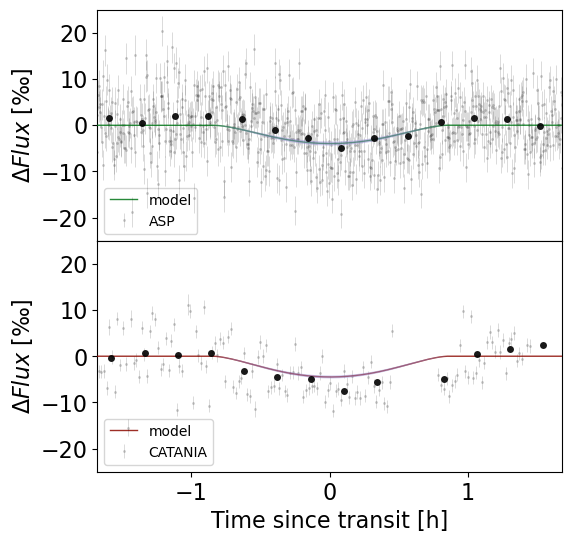

In [215]:
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize=(6, 6))
fig.subplots_adjust(hspace=0)
for n, name in enumerate(extra_datasets):
    ax = axes[n]
    # plot the folded transits
    x, y, yerr = extra_datasets[name][:3]
    folded = (x - t0_ + 0.5 * p_) % p_ - 0.5 * p_
    if n == 0:
        mean = np.median(flat_samps["muscat_i_mean"])
        #ax.plot(folded*24, (y  - mean), ".k", alpha=0.4, label=f"{name}", mec="none", ms=5)
        ax.errorbar(folded*24, (y  - mean), yerr=yerr, fmt='o', color='b', capsize=1, elinewidth=0.5, ecolor='k',
                    ms=2, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.2, zorder=7, label=f"{name}")
        # Overplot the phase binned light curve with rmse as error bars
        lcc = lk.LightCurve(time=folded, flux=y - mean, flux_err=yerr)
        lcc_binned = lcc.bin(time_bin_size=0.01)
        ax.plot(lcc_binned['time'].value*24, lcc_binned['flux'].value, 'o', color='k',
                ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.9, zorder=9)
        # ax.errorbar(lcc_binned['time'].value*24, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
        #             ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.9, zorder=900)
        # overplot the model
        pred = np.percentile(flat_samps["muscat_i_lc_pred"], [16, 50, 84], axis=-1)
        ax.plot(phase_lc*24, pred[1], color=f"C{n+1}", label="model", zorder=8, linewidth=1, alpha=0.85)
        art = ax.fill_between(phase_lc*24, pred[0], pred[2], color="#988ED5", alpha=0.5, zorder=8)
        art.set_edgecolor("none")
        ax.legend(fontsize=10, loc=3)
    else:
        mean = np.median(flat_samps["keplercam_B_mean"])
        #ax.plot(folded*24, (y  - mean), ".k", alpha=0.4, label=f"{name}", mec="none", ms=5)
        ax.errorbar(folded*24, (y  - mean), yerr=yerr, fmt='o', color='b', capsize=1, elinewidth=0.5, ecolor='k',
                    ms=2, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.2, zorder=7, label=f"{name}")
        # Overplot the phase binned light curve with rmse as error bars
        lcc = lk.LightCurve(time=folded, flux=y - mean, flux_err=yerr)
        lcc_binned = lcc.bin(time_bin_size=0.01)
        ax.plot(lcc_binned['time'].value*24, lcc_binned['flux'].value, 'o', color='k',
                    ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.9, zorder=10)
        # overplot the model
        pred = np.percentile(flat_samps["keplercam_B_lc_pred"], [16, 50, 84], axis=-1)
        ax.plot(phase_lc*24, pred[1], color=f"C{n+1}", label="model", zorder=8, linewidth=1, alpha=0.85)
        art = ax.fill_between(phase_lc*24, pred[0], pred[2], color="#988ED5", alpha=0.5, zorder=8)
        art.set_edgecolor("none")
        ax.legend(fontsize=10, loc=3)
axes[-1].set_xlim(-0.07*24, 0.07*24)
axes[-1].set_xlabel("Time since transit [h]")
axes[-1].set_ylim(-25, 25)
for ax in axes:
    ax.set_ylabel(u'$\Delta Flux$ [‰]')
#plt.tight_layout()